In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
# import LogNorm
from matplotlib.colors import LogNorm


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [2]:
from events_data import events_from_scdinfo
from tst_info import TSTInfo
from debiasing import get_bias_fn, get_histograms
from plots import hist_events_by_labels
import tqdm

def piecewise_linear(x_knots, y_knots):
    def piecewise_linear_inner(x):
        return np.interp(x, x_knots, y_knots)
    return piecewise_linear_inner

def draw_routine(hashes, rw_methods=["CR"], debias_list=[None, "all", "binwise"], calibration_nbin=8, 
                 test_nbin=10):
    assert all(debias in [None, "all", "binwise"] for debias in debias_list)
    device = torch.device("cuda")
    for tstinfo_hash in tqdm.tqdm(hashes):
        tstinfo = TSTInfo.load(tstinfo_hash)
        signal_filename = tstinfo.hparams["signal_filename"]
        seed = tstinfo.hparams["seed"]
        signal_ratio = tstinfo.hparams["signal_ratio"]

        scdinfo_tst = tstinfo.scdinfo_tst
        events_tst = events_from_scdinfo(
            scdinfo_tst, features, signal_filename)

        base_fvt_hash = tstinfo.base_fvt_tinfo_hash
        fvt_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
        fvt_model.to(device)
        fvt_model.freeze()

        CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
        CR_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
        CR_model.to(device)
        CR_model.freeze()

        SR_stats = tstinfo.SR_stats
        SR_cut = tstinfo.SR_cut
        CR_cut = tstinfo.CR_cut
        in_SR = SR_stats >= SR_cut
        in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

        ratio_4b = tstinfo.hparams["ratio_4b"]

        for rw_method in rw_methods:
            if rw_method == "CR":
                probs_4b_est = CR_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]
            else:
                probs_4b_est = fvt_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]

            reweights = ratio_4b * probs_4b_est / \
                ((1 - ratio_4b) * (1 - probs_4b_est))
        
            for debias in debias_list:
                if debias == "all":
                    bias_fn = get_bias_fn(events_tst, probs_4b_est, calibration_nbin)
                    bias_3b_rw = bias_fn(probs_4b_est)
                elif debias == "binwise":
                    bias_3b_rw = np.zeros_like(probs_4b_est)
                    
                    q = np.linspace(0, 1, test_nbin+1)
                    for SR_stats_inner, in_region_inner in zip([SR_stats_CR, SR_stats_SR], [in_CR, in_SR]):
                        region_bins = np.quantile(SR_stats_inner, q)
                        region_bins_idx = np.digitize(SR_stats_inner, region_bins)
                        region_bins_idx = np.clip(region_bins_idx, 1, len(q) - 1)
                        CR_idx = np.where(in_region_inner)[0]
                        
                        for i in np.unique(region_bins_idx):
                            in_this_bin = CR_idx[region_bins_idx == i]
                            probs_4b_est_bin = probs_4b_est[in_this_bin]
                            calibration_bins = np.linspace(np.min(probs_4b_est_bin), 
                                                        np.max(probs_4b_est_bin), 
                                                        calibration_nbin + 1)
                            
                            midpoints = (calibration_bins[1:] + calibration_bins[:-1]) / 2
                            
                            hist_4b, _ = np.histogram(probs_4b_est_bin[events_tst.is_4b[in_this_bin]],
                                                        bins=calibration_bins,
                                                        weights=(events_tst.weights[in_this_bin])[events_tst.is_4b[in_this_bin]])
                            hist_all, _ = np.histogram(probs_4b_est_bin,
                                                        bins=calibration_bins,
                                                        weights=(events_tst.weights[in_this_bin]))
                            mean_probs_4b = hist_4b / hist_all
                            calibration_error = np.nan_to_num(midpoints - mean_probs_4b, nan=0)
                            
                            calibration_error_fn = piecewise_linear(midpoints, calibration_error)
                            bias_3b_rw[in_this_bin] = calibration_error_fn(probs_4b_est_bin) * (1 / (1 - probs_4b_est_bin))**2
                        
                    
                else:
                    bias_3b_rw = np.zeros_like(probs_4b_est)

                events_SR = events_tst[in_SR]
                events_CR = events_tst[in_CR]
                SR_stats_SR = SR_stats[in_SR]
                SR_stats_CR = SR_stats[in_CR]

                events_tst_rw = events_tst.clone()
                # include bias
                events_tst_rw.reweight(
                    np.where(events_tst_rw.is_4b, events_tst_rw.weights, events_tst_rw.weights * (reweights - bias_3b_rw)))
                events_SR_rw = events_tst_rw[in_SR]
                events_CR_rw = events_tst_rw[in_CR]

                fig = plt.figure(figsize=(12, 8))
                fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}, reweighting={rw_method}, debias={debias}")
                gs = GridSpec(3, 2, figure=fig)

                # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), test_nbin+1)
                q = np.linspace(0, 1, test_nbin+1)
                bins = np.quantile(SR_stats_CR, q)

                ax = fig.add_subplot(gs[0, 0])
                hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("CR")
                ax.legend()

                histograms = get_histograms(
                    events_CR, SR_stats_CR, bins, reweights[in_CR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_bg4b = histograms["bg4b"]
                hist_4b = histograms["4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins,
                                                    weights=(events_CR.weights * bias_3b_rw[in_CR])[events_CR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                q = np.linspace(0, 1, test_nbin+1)
                bins = np.quantile(SR_stats_SR, q)

                ax = fig.add_subplot(gs[0, 1])
                hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("SR")
                ax.legend()

                histograms = get_histograms(
                    events_SR, SR_stats_SR, bins, reweights[in_SR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_4b = histograms["4b"]
                hist_bg4b = histograms["bg4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_SR[events_SR.is_3b], bins=bins,
                                                    weights=(events_SR.weights * bias_3b_rw[in_SR])[events_SR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                plt.tight_layout()
                plt.show()

In [3]:
def plot_hist_and_ratio(tstinfo: TSTInfo, 
                    x_values: np.ndarray, 
                    events_tst_clone: EventsData, 
                    events_tst_original: EventsData,
                    in_CR: np.ndarray, 
                    in_SR: np.ndarray, 
                    nbins: int = 10,
                    bins_mode: str = "quantile",
                    ylim: tuple[float, float] = (0.5, 1.5), 
                    xlabel: str = None,
                    yscale: str = "linear", 
                    title: str = None, 
                    scale_original: bool = False, 
                    do_bg4b: bool=False):
    assert len(x_values) == len(events_tst_clone)
    
    if bins_mode == "quantile":
        bins_CR = np.quantile(x_values[in_CR], np.linspace(0, 1, nbins))
        bins_SR = np.quantile(x_values[in_SR], np.linspace(0, 1, nbins))
    else:
        bins_CR = np.linspace(np.min(x_values[in_CR]), np.max(x_values[in_CR]), nbins)
        bins_SR = np.linspace(np.min(x_values[in_SR]), np.max(x_values[in_SR]), nbins)
        

    gs = GridSpec(3, 2)
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(title)
    fig.supxlabel(xlabel)
    
    tst_fvt_scores_CR = x_values[in_CR]
    events_tst_clone_CR = events_tst_clone[in_CR]
    events_tst_original_CR = events_tst_original[in_CR]
    
    if not do_bg4b:
        hist_4b_CR, _ = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_4b])
    else:
        hist_4b_CR = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_bg4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_bg4b])[0]
    hist_signal_CR, _ = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_signal], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_signal])
    hist_3b_CR, _ = np.histogram(tst_fvt_scores_CR[~events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[~events_tst_clone_CR.is_4b])
    hist_3b_CR_original, _ = np.histogram(tst_fvt_scores_CR[~events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_original_CR.weights[~events_tst_original_CR.is_4b])
    reweights = events_tst_clone_CR.weights / events_tst_original_CR.weights
    hist_3b_sq_CR_original, _ = np.histogram(tst_fvt_scores_CR[~events_tst_original_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=(reweights**2 * events_tst_original_CR.weights)[~events_tst_original_CR.is_4b])
    
    if scale_original:
        hist_3b_CR_original = hist_3b_CR_original * np.sum(hist_4b_CR) / np.sum(hist_3b_CR_original)

        
    
    ax = fig.add_subplot(gs[:2, 0])
    ax.set_title("Control Region")
    ax.stairs(hist_3b_CR, bins_CR, label="Reweighted 3b", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_3b_CR_original, bins_CR, label="3b original", linestyle="--", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_4b_CR, bins_CR, label="4b", color=plt.get_cmap("tab10").colors[1])
    ax.stairs(hist_signal_CR, bins_CR, label="Signal", color=plt.get_cmap("tab10").colors[2])
    ax.errorbar((bins_CR[1:] + bins_CR[:-1]) / 2, 
                hist_4b_CR, 
                yerr=np.sqrt(hist_4b_CR + hist_3b_sq_CR_original), 
                fmt="o", markersize=3, capsize=3, 
                color=plt.get_cmap("tab10").colors[1])
    ax.set_yscale(yscale)
    ax.legend()
    
    ax = fig.add_subplot(gs[2, 0])
    ax.errorbar((bins_CR[1:] + bins_CR[:-1]) / 2, hist_4b_CR / hist_3b_CR, 
                yerr=np.sqrt(hist_4b_CR + hist_3b_sq_CR_original) / hist_3b_CR, 
                fmt="o", markersize=3, label="4b / Reweighted 3b", capsize=3, 
                color=plt.get_cmap("tab10").colors[0])
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 0.1, 0.1))  # Set y ticks from 0.5 to 1.5 with interval 0.1
    ax.set_yticklabels([ylim[0]] + [None] * 4 + [(ylim[0] + ylim[1]) / 2] + [None] * 4 + [ylim[1]])
    
    ax.set_ylabel("True 4b / Modeled 4b")
    ax.hlines(1, bins_CR[0], bins_CR[-1], color="black", linestyle="--")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins_CR[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)
    
    # get histogram of 4b, 3b in SR
    tst_fvt_scores_SR = x_values[in_SR]
    events_tst_clone_SR = events_tst_clone[in_SR]
    events_tst_original_SR = events_tst_original[in_SR]
    
    if not do_bg4b:
        hist_4b_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_4b])
    else:
        hist_4b_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_bg4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_bg4b])
        
    hist_3b_SR, _ = np.histogram(tst_fvt_scores_SR[~events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[~events_tst_clone_SR.is_4b])
    hist_signal_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_signal], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_signal])
    hist_3b_SR_original, _ = np.histogram(tst_fvt_scores_SR[~events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_original_SR.weights[~events_tst_original_SR.is_4b])
    reweights = events_tst_clone_SR.weights / events_tst_original_SR.weights
    hist_3b_sq_SR_original, _ = np.histogram(tst_fvt_scores_SR[~events_tst_original_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=(reweights**2 * events_tst_original_SR.weights)[~events_tst_original_SR.is_4b])
    
    if scale_original:
        hist_3b_SR_original = hist_3b_SR_original * np.sum(hist_4b_SR) / np.sum(hist_3b_SR_original)
    
    ax = fig.add_subplot(gs[:2, 1])
    ax.set_title("Signal Region")
    ax.stairs(hist_3b_SR, bins_SR, label="Reweighted 3b", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_3b_SR_original, bins_SR, label="3b original", linestyle="--", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_4b_SR, bins_SR, label="4b", color=plt.get_cmap("tab10").colors[1])
    ax.stairs(hist_signal_SR, bins_SR, label="Signal", color=plt.get_cmap("tab10").colors[2])
    ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, 
                hist_4b_SR, 
                yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original), 
                fmt="o", markersize=3, capsize=3, 
                color=plt.get_cmap("tab10").colors[1])
    ax.set_yscale(yscale)
    ax.legend()
    
    ax = fig.add_subplot(gs[2, 1])
    ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, hist_4b_SR / hist_3b_SR, 
                yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original) / hist_3b_SR, 
                fmt="o", markersize=3, label="4b / Reweighted 3b", capsize=3, 
                color=plt.get_cmap("tab10").colors[0])
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 0.1, 0.1))  # Set y ticks from 0.5 to 1.5 with interval 0.1
    ax.set_yticklabels([ylim[0]] + [None] * 4 + [(ylim[0] + ylim[1]) / 2] + [None] * 4 + [ylim[1]])
    
    ax.set_ylabel("True 4b / Modeled 4b")
    ax.hlines(1, bins_SR[0], bins_SR[-1], color="black", linestyle="--")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins_SR[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)
    
    # plt.show()
    # plt.close()

In [4]:
def get_sigma_avg(events: EventsData, hist_values: np.ndarray, bins, reweights: np.ndarray):
    hist_3b, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=events.weights[events.is_3b])
    hist_4b, _ = np.histogram(hist_values[events.is_4b], bins=bins, 
                                weights=events.weights[events.is_4b])
    hist_3b_sq, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=(events.weights * reweights)[events.is_3b])
    sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    return sigma_avg

def plot_reweighted_samples(events_reweighted: EventsData, 
                            events_not_reweighted: EventsData,
                            hist_values: np.ndarray, 
                            fig: plt.Figure):
    gs = GridSpec(2, 2, figure=fig)
    for ax_cnt, quantile in enumerate([True, False]):
        if quantile:
            q = np.linspace(0, 1, 10)
            bins = np.quantile(hist_values, q)
        else:
            bins = np.linspace(np.min(hist_values), np.max(hist_values), 10)

        ax = fig.add_subplot(gs[ax_cnt, 0])
        hist_events_by_labels(events_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("Reweighted")
        ax.legend()
        ax = fig.add_subplot(gs[ax_cnt, 1])
        hist_events_by_labels(events_not_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("NOT Reweighted")
        ax.legend()

In [5]:
from matplotlib.colors import LogNorm

from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from signal_region import get_SR_stats
import itertools

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


n_3b=1000000, signal_ratio=0.0, seed=0


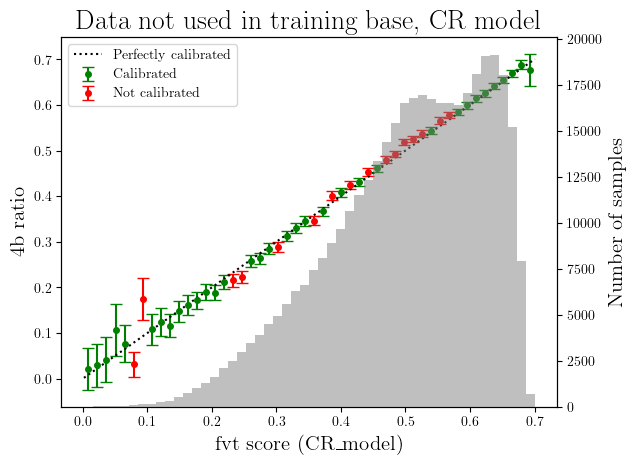

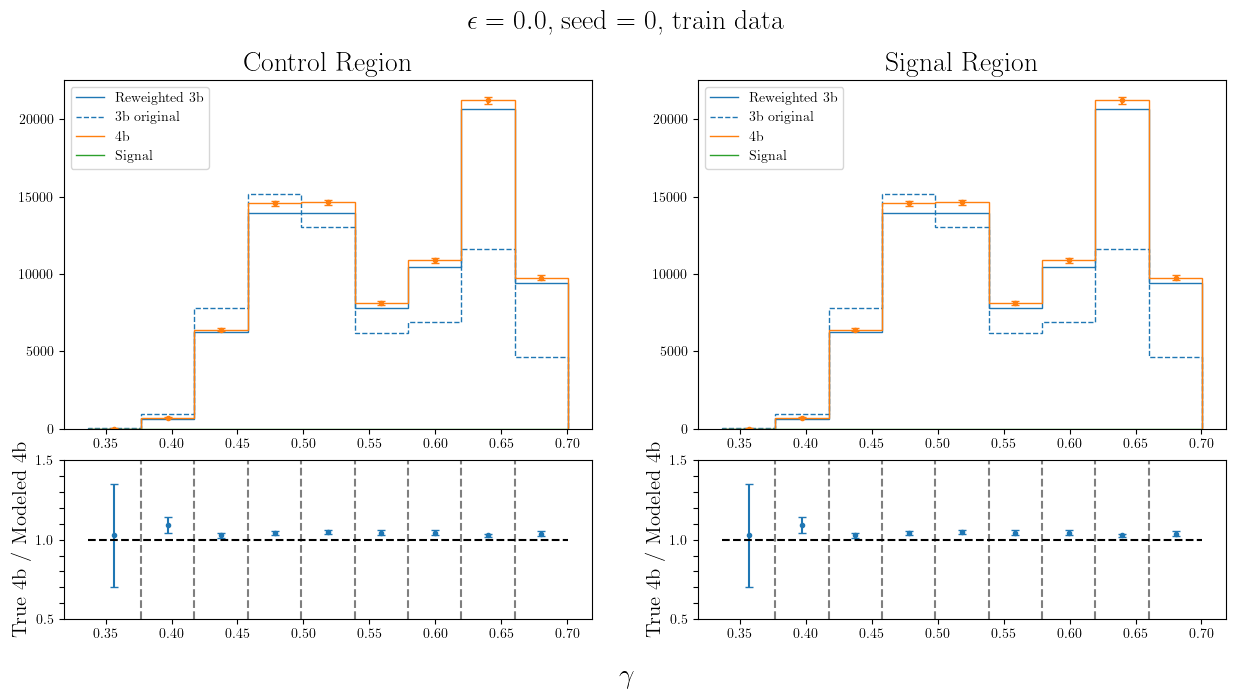

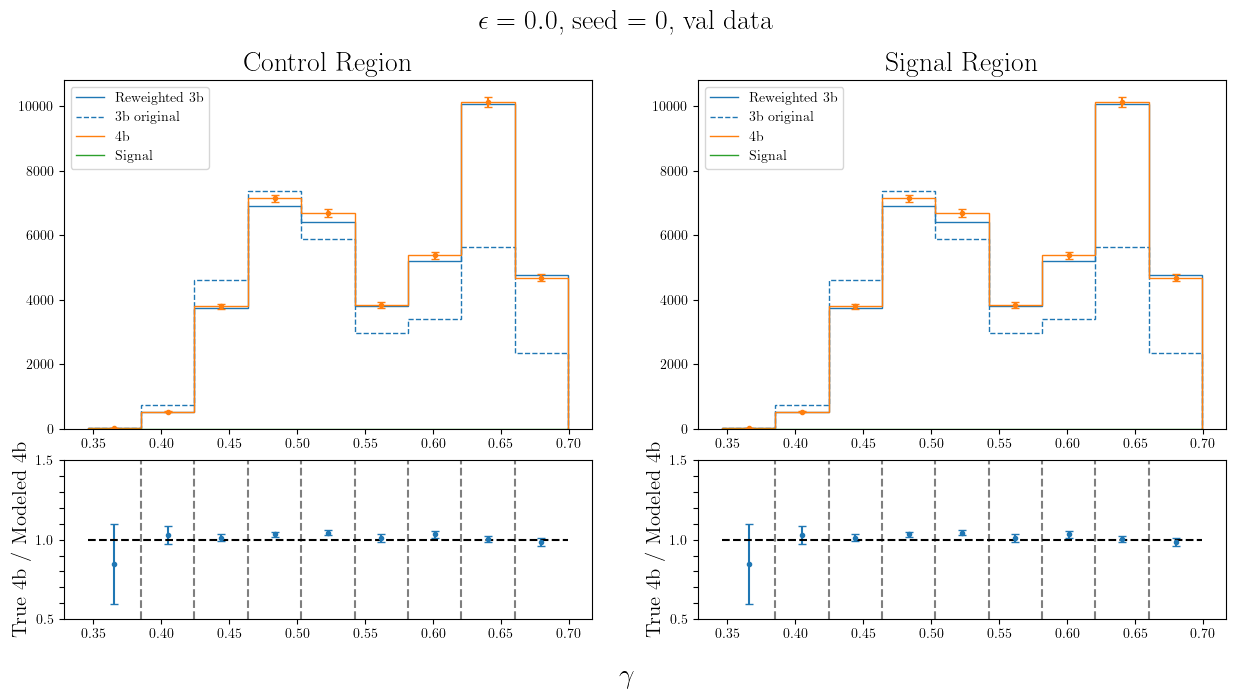

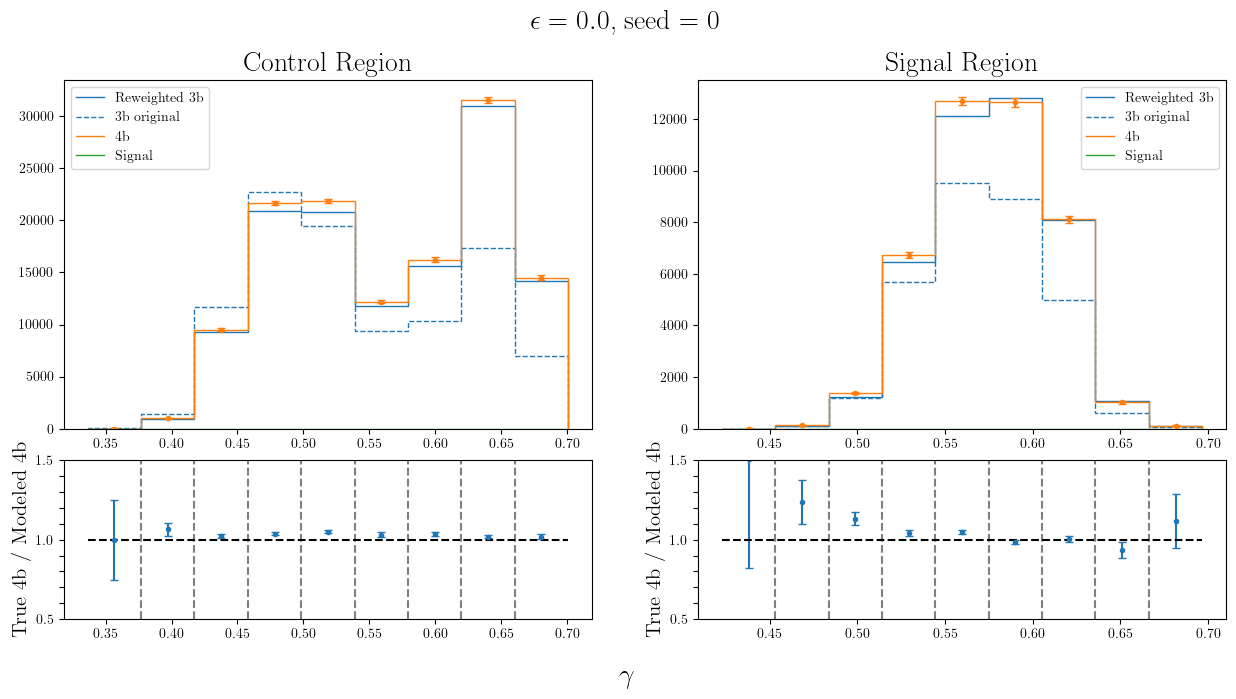

n_3b=1000000, signal_ratio=0.01, seed=0


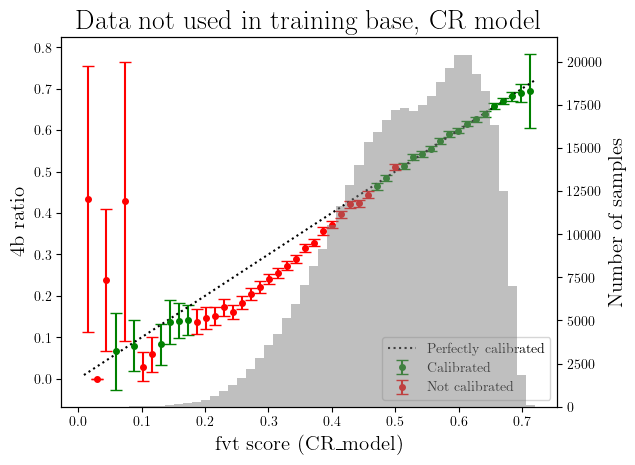

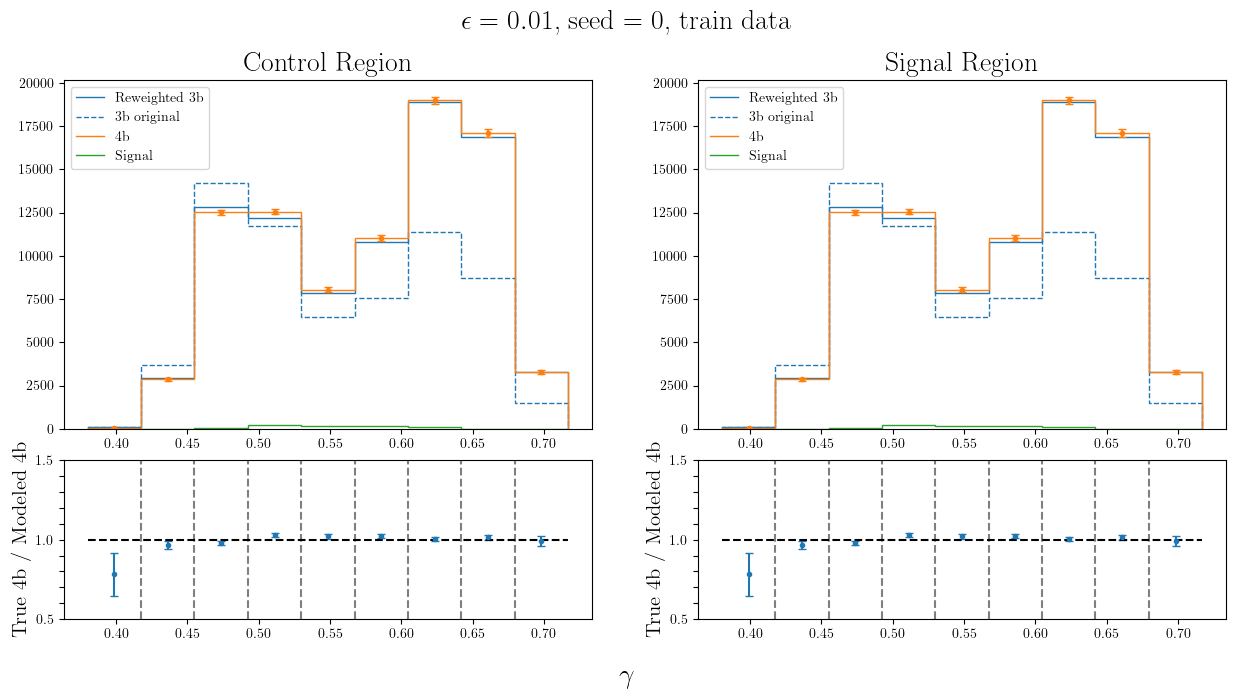

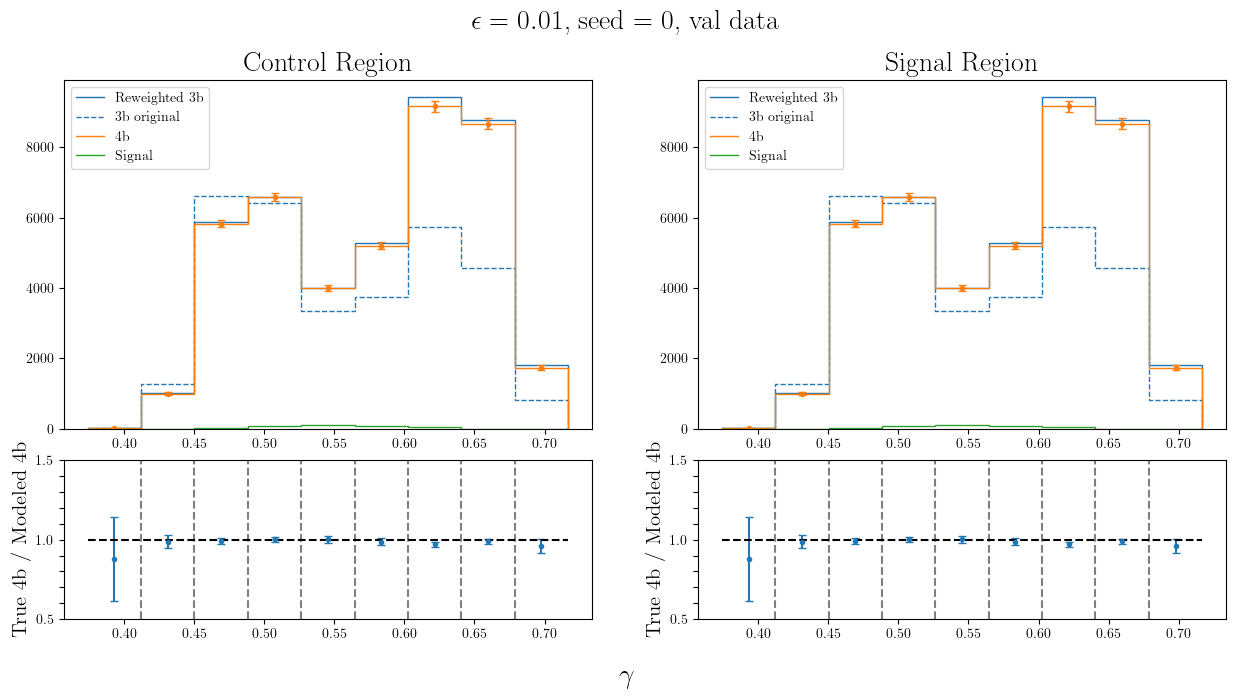

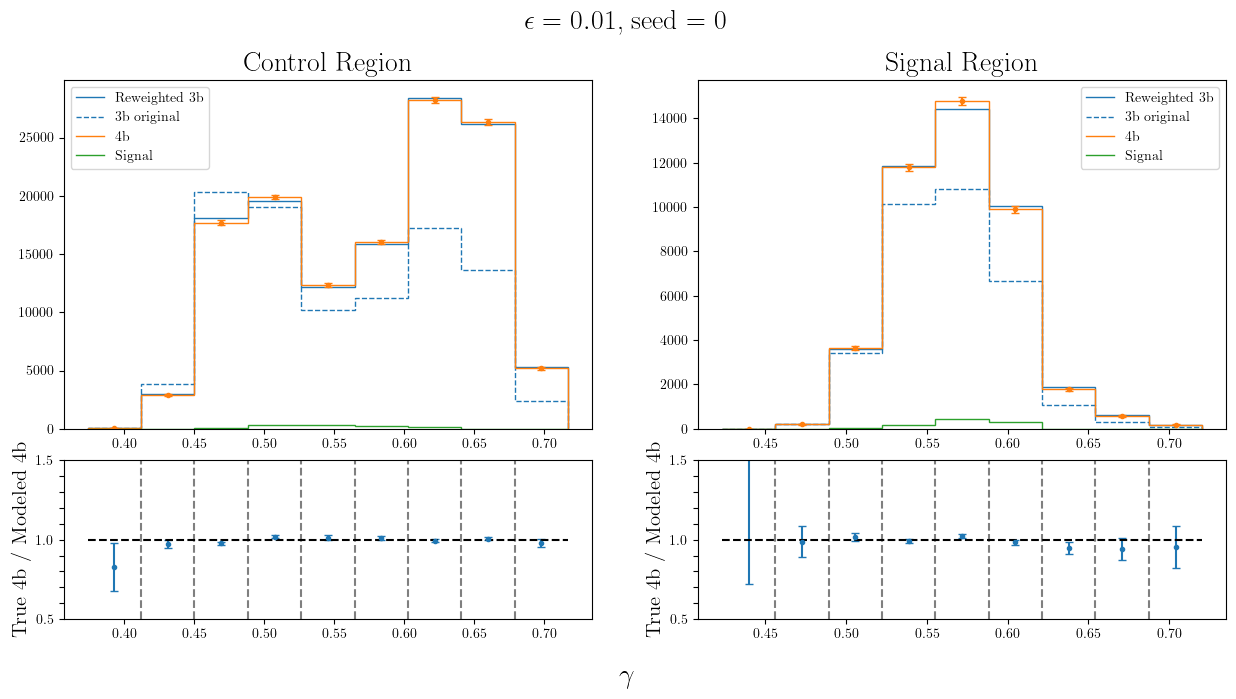

n_3b=1000000, signal_ratio=0.02, seed=0


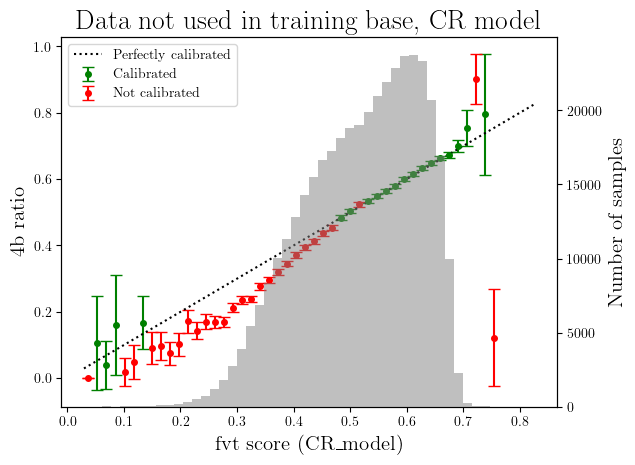

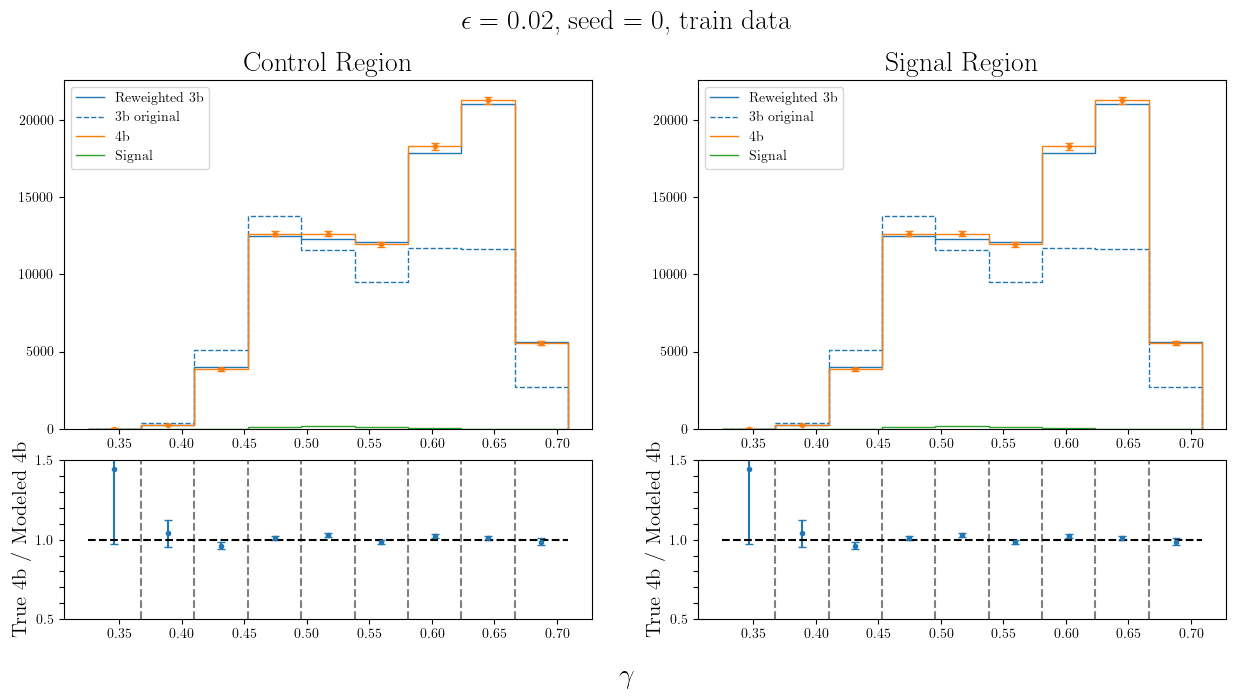

KeyboardInterrupt: 

In [ ]:
from training_info import TrainingInfoV2
from plots import calibration_plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "seed": lambda x: x in [0],
    "signal_ratio": 0.0
}

hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    CR_model = FvTClassifier.load_from_checkpoint(f"data/checkpoints/{CR_fvt_tinfo.hash}_best.ckpt")
    CR_model.to(device)
    CR_model.eval()
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)
    
    tst_fvt_scores = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    
    fig, ax = plt.subplots()
    calibration_plot(tst_fvt_scores, events_tst.is_4b, bins=50, sample_weights=events_tst.weights, ax=ax)
    ax.set_xlabel("fvt score (CR_model)")
    ax.set_ylabel("4b ratio")
    ax.set_title("Data not used in training base, CR model")
    plt.show()
    plt.close()
    
    # check correlation between SR stat and fvt score
    SR_stat = tstinfo.SR_stats
    reweights = tst_fvt_scores / (1 - tst_fvt_scores) * (ratio_4b / (1 - ratio_4b))
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    
    in_SR = SR_stat >= SR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    
    events_tst_clone = events_tst.clone()
    events_tst_clone.reweight(np.where(events_tst_clone.is_4b, 
                                        events_tst_clone.weights, 
                                        events_tst_clone.weights * reweights))
    bg_in_SR = (~events_tst_clone.is_signal) & in_SR
    SR_stat_CR = SR_stat[in_CR]
    events_tst_clone_CR = events_tst_clone[in_CR]

    train_fvt_scores = CR_model.predict(events_train.X_torch).detach().cpu().numpy()[:, 1]
    events_train_clone = events_train.clone()
    reweights = train_fvt_scores / (1 - train_fvt_scores) * (ratio_4b / (1 - ratio_4b))
    events_train_clone.reweight(np.where(events_train_clone.is_4b, 
                                        events_train_clone.weights, 
                                        events_train_clone.weights * reweights))
    
    val_fvt_scores = CR_model.predict(events_val.X_torch).detach().cpu().numpy()[:, 1]
    events_val_clone = events_val.clone()
    reweights = val_fvt_scores / (1 - val_fvt_scores) * (ratio_4b / (1 - ratio_4b))
    events_val_clone.reweight(np.where(events_val_clone.is_4b, 
                                        events_val_clone.weights, 
                                        events_val_clone.weights * reweights))

    plot_hist_and_ratio(tstinfo, train_fvt_scores, events_train_clone, events_train, 
                        np.ones(len(events_train), dtype=bool), 
                        np.ones(len(events_train), dtype=bool), 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}, train data")
    
    plot_hist_and_ratio(tstinfo, val_fvt_scores, events_val_clone, events_val, 
                        np.ones(len(events_val), dtype=bool), 
                        np.ones(len(events_val), dtype=bool), 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}, val data")
    # plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
    #                     bins_mode="quantile",
    #                     nbins=10,
    #                     xlabel=r"$\gamma / \widetilde{\gamma}$", 
    #                     title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    # plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
    #                     bins_mode="quantile",
    #                     nbins=10,
    #                     xlabel=r"$\gamma / \widetilde{\gamma}$", 
    #                     title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}",
    #                     scale_original=True)
    # plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
    #                     bins_mode="uniform",
    #                     nbins=10,
    #                     xlabel=r"$\gamma / \widetilde{\gamma}$", 
    #                     title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    plot_hist_and_ratio(tstinfo, tst_fvt_scores, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    
    plt.show()
    plt.close()


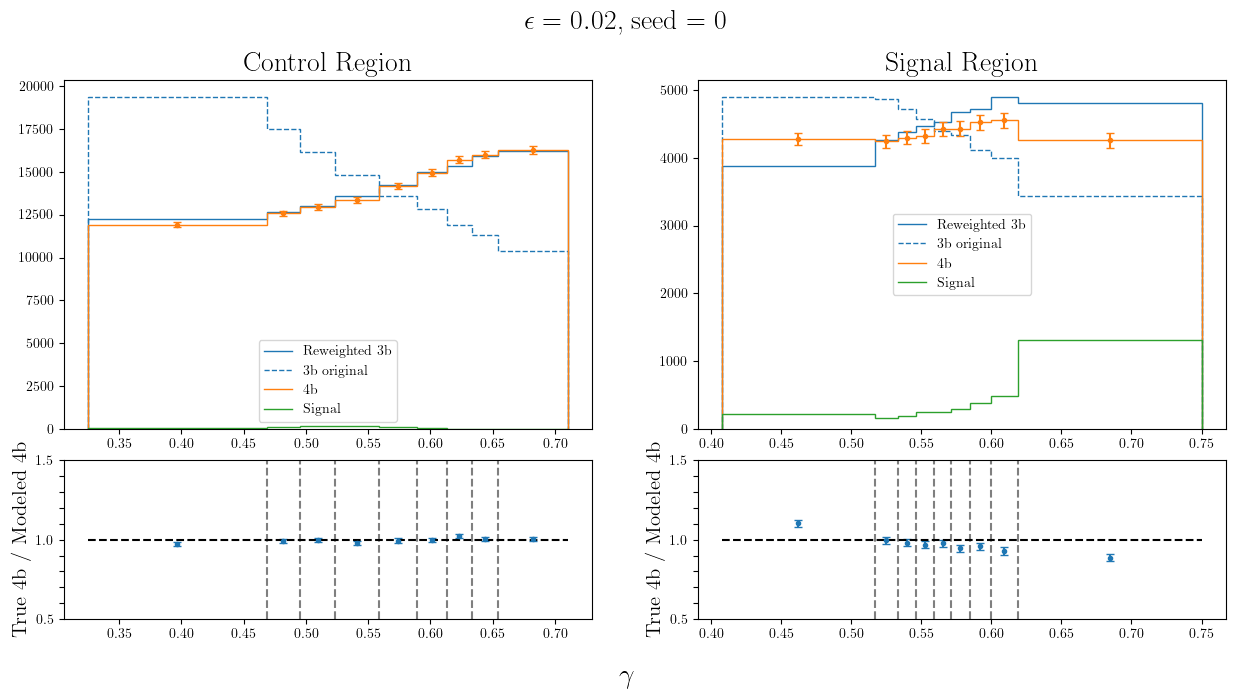

In [7]:
plot_hist_and_ratio(tstinfo, tst_fvt_scores, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="quantile",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}", 
                        do_bg4b=True, scale_original=True)

n_3b=1000000, signal_ratio=0.0, seed=0


[rank: 0] Seed set to 0


Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
[n01:2229766] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.n01.3393/jf.0/2709848064/shared_mem_cuda_pool.n01 could be created.
[n01:2229766] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is t

Epoch 49: 100%|██████████| 141/141 [00:11<00:00, 12.44it/s, v_num=9, val_loss=0.677, val_ce_loss=0.675, val_cal_loss=0.0138, train_loss=0.675, train_ce_loss=0.673, train_cal_loss=0.0117]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 141/141 [00:11<00:00, 12.40it/s, v_num=9, val_loss=0.677, val_ce_loss=0.675, val_cal_loss=0.0138, train_loss=0.675, train_ce_loss=0.673, train_cal_loss=0.0117]


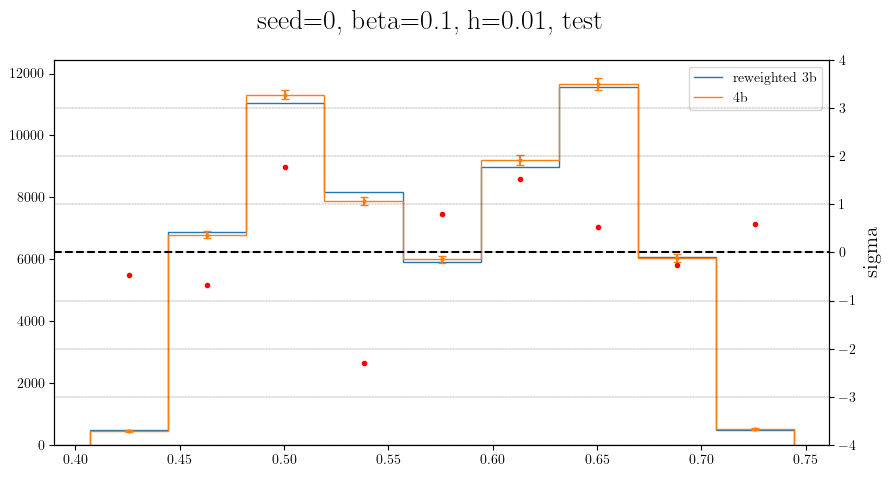

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 49: 100%|██████████| 141/141 [00:07<00:00, 19.59it/s, v_num=10, val_loss=0.677, val_ce_loss=0.675, val_cal_loss=0.015, train_loss=0.674, train_ce_loss=0.673, train_cal_loss=0.0123] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 141/141 [00:07<00:00, 19.56it/s, v_num=10, val_loss=0.677, val_ce_loss=0.675, val_cal_loss=0.015, train_loss=0.674, train_ce_loss=0.673, train_cal_loss=0.0123]


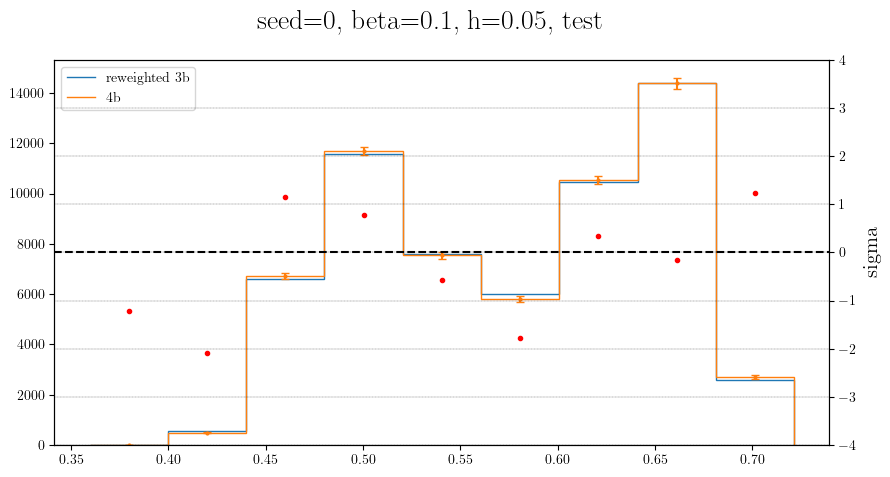

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 26: 100%|██████████| 141/141 [00:07<00:00, 19.22it/s, v_num=11, val_loss=0.679, val_ce_loss=0.676, val_cal_loss=0.0329, train_loss=0.677, train_ce_loss=0.674, train_cal_loss=0.0322]


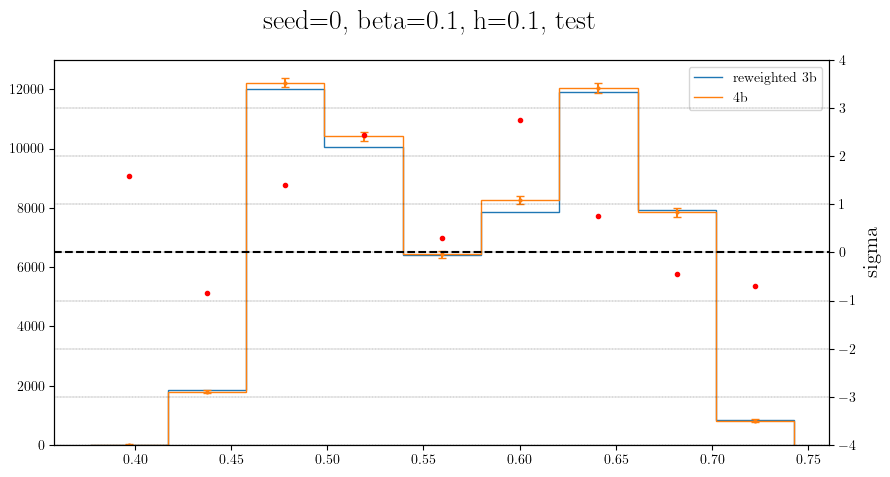

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 22: 100%|██████████| 141/141 [00:07<00:00, 19.97it/s, v_num=12, val_loss=0.680, val_ce_loss=0.677, val_cal_loss=0.0278, train_loss=0.677, train_ce_loss=0.674, train_cal_loss=0.030] 


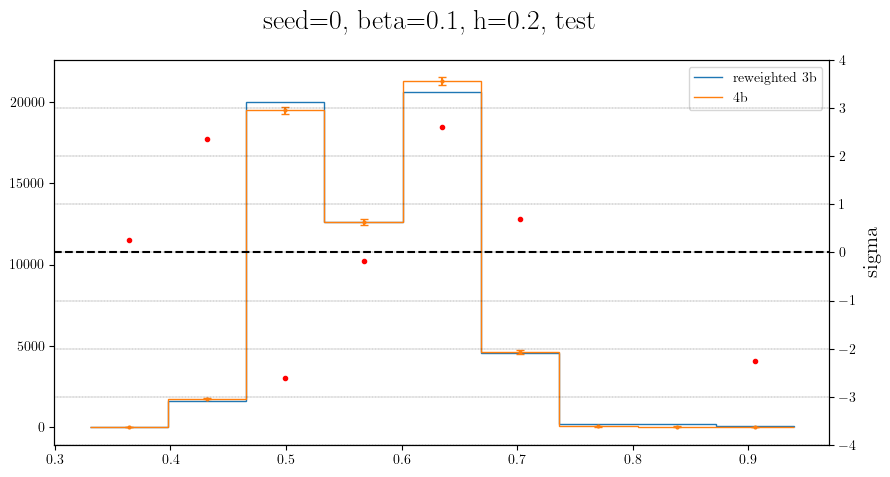

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 14: 100%|██████████| 141/141 [00:07<00:00, 19.27it/s, v_num=5, val_loss=0.676, val_ce_loss=0.676, val_cal_loss=0.185, train_loss=0.674, train_ce_loss=0.674, train_cal_loss=0.187]


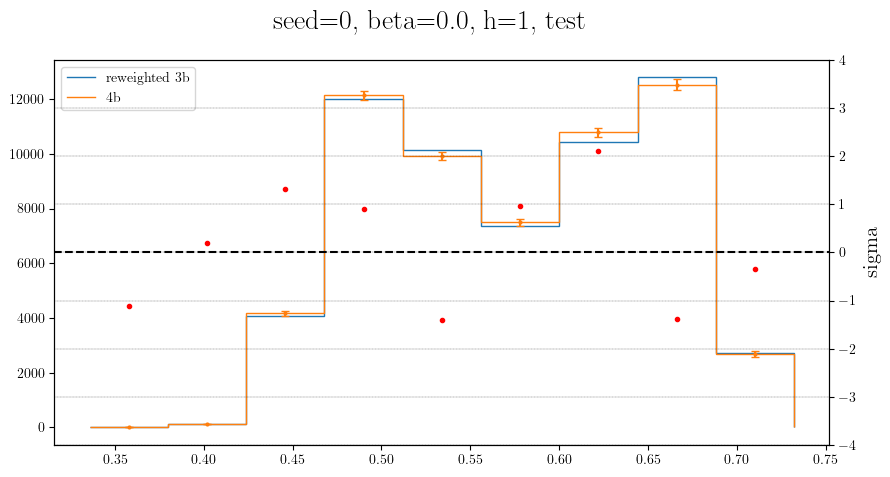

n_3b=1000000, signal_ratio=0.0, seed=1


[rank: 0] Seed set to 1
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 22: 100%|██████████| 145/145 [00:08<00:00, 16.47it/s, v_num=13, val_loss=0.689, val_ce_loss=0.685, val_cal_loss=0.033, train_loss=0.686, train_ce_loss=0.683, train_cal_loss=0.0378] 


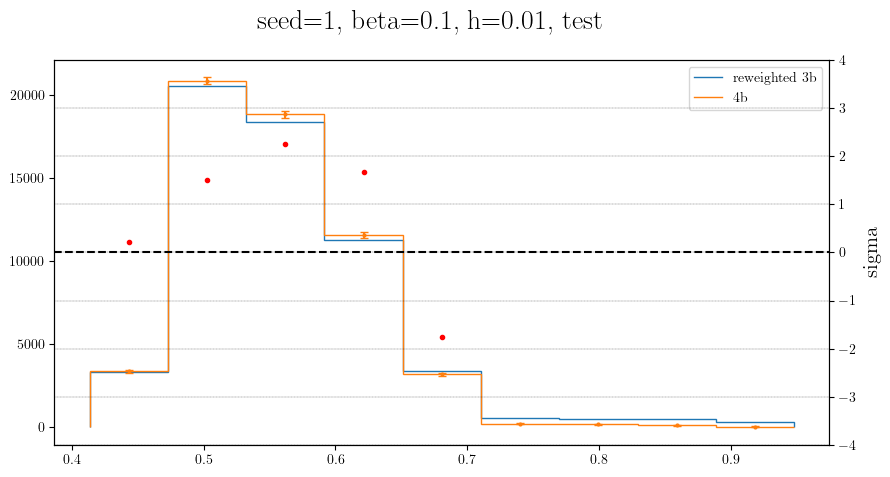

[rank: 0] Seed set to 1
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 15: 100%|██████████| 145/145 [00:09<00:00, 15.37it/s, v_num=14, val_loss=0.687, val_ce_loss=0.684, val_cal_loss=0.0324, train_loss=0.686, train_ce_loss=0.682, train_cal_loss=0.0342]


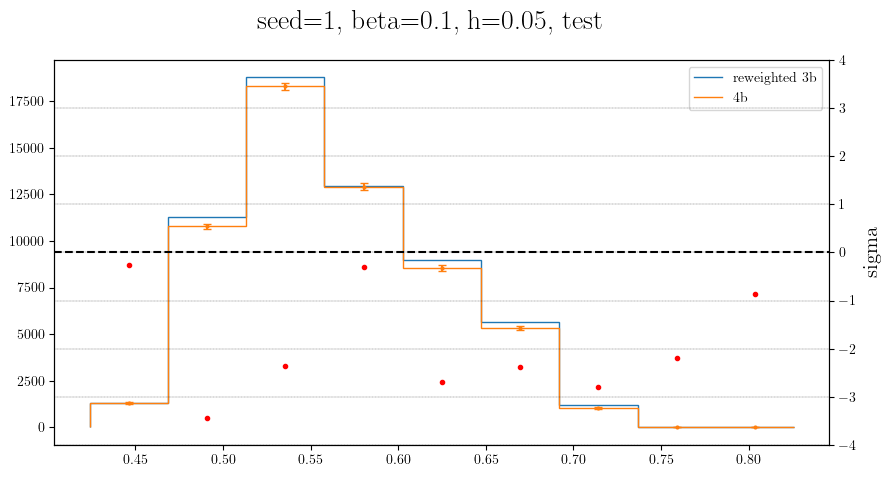

[rank: 0] Seed set to 1
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 49: 100%|██████████| 145/145 [00:10<00:00, 13.54it/s, v_num=15, val_loss=0.685, val_ce_loss=0.683, val_cal_loss=0.0233, train_loss=0.684, train_ce_loss=0.682, train_cal_loss=0.022] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 145/145 [00:10<00:00, 13.53it/s, v_num=15, val_loss=0.685, val_ce_loss=0.683, val_cal_loss=0.0233, train_loss=0.684, train_ce_loss=0.682, train_cal_loss=0.022]


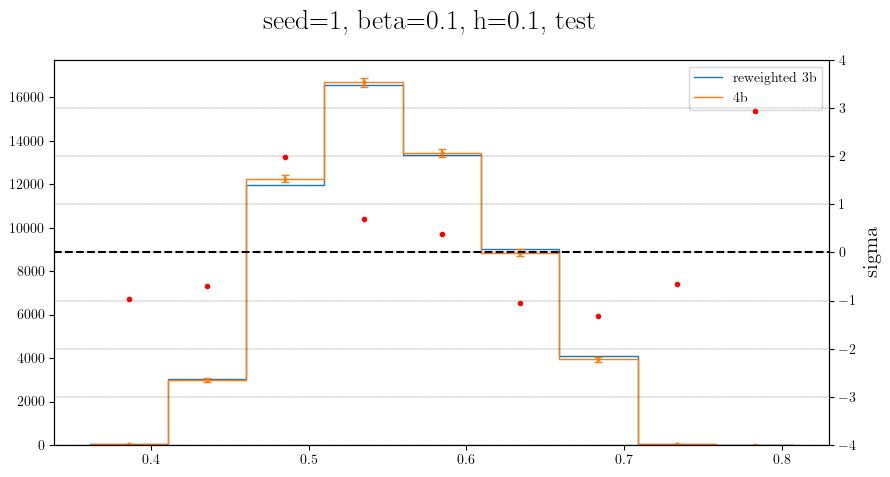

[rank: 0] Seed set to 1
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 27: 100%|██████████| 145/145 [00:07<00:00, 18.29it/s, v_num=16, val_loss=0.687, val_ce_loss=0.683, val_cal_loss=0.0334, train_loss=0.686, train_ce_loss=0.682, train_cal_loss=0.037] 


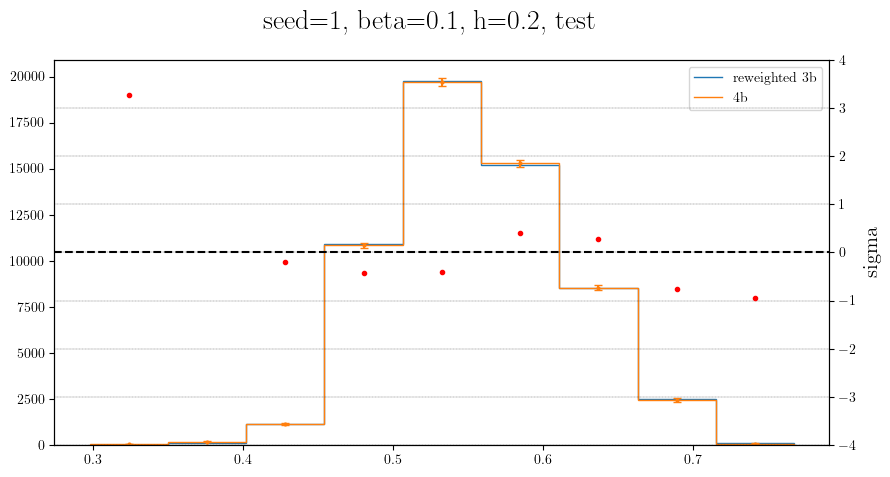

[rank: 0] Seed set to 1
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 40: 100%|██████████| 145/145 [00:07<00:00, 19.24it/s, v_num=6, val_loss=0.683, val_ce_loss=0.683, val_cal_loss=0.132, train_loss=0.681, train_ce_loss=0.681, train_cal_loss=0.131]


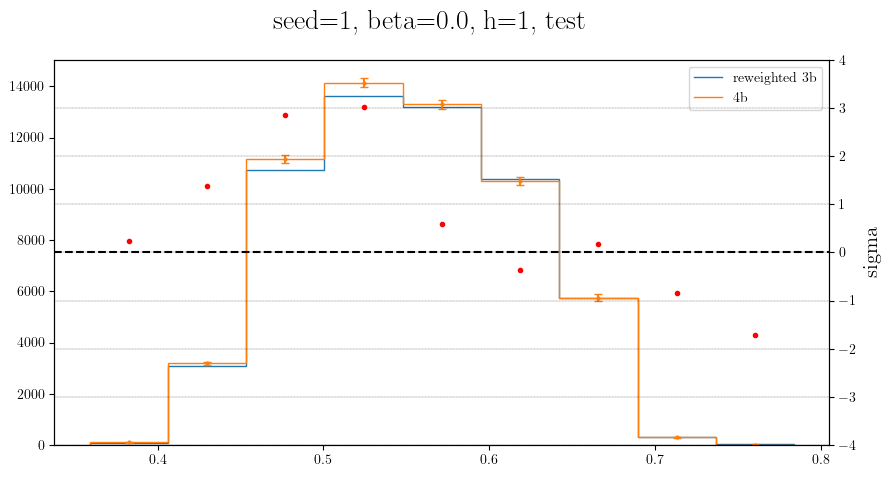

n_3b=1000000, signal_ratio=0.0, seed=2


[rank: 0] Seed set to 2
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 20: 100%|██████████| 141/141 [00:07<00:00, 18.80it/s, v_num=17, val_loss=0.680, val_ce_loss=0.675, val_cal_loss=0.0472, train_loss=0.681, train_ce_loss=0.676, train_cal_loss=0.0462]


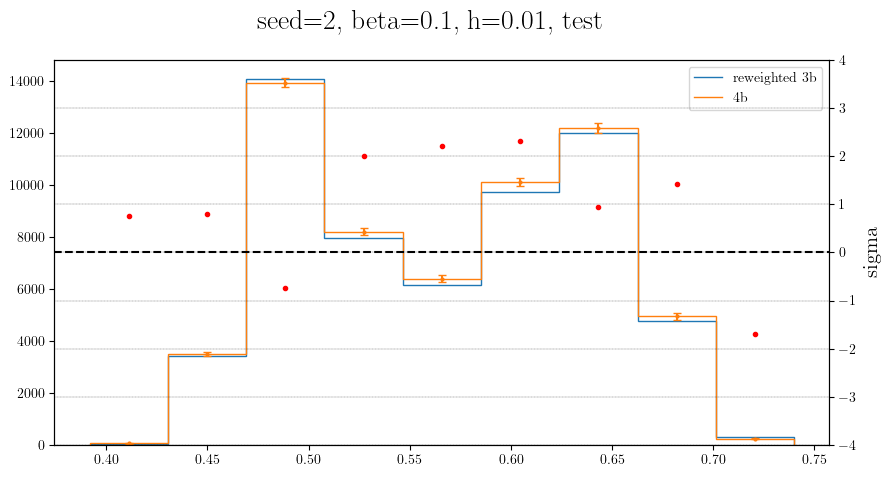

[rank: 0] Seed set to 2
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 20: 100%|██████████| 141/141 [00:07<00:00, 19.20it/s, v_num=18, val_loss=0.678, val_ce_loss=0.675, val_cal_loss=0.030, train_loss=0.679, train_ce_loss=0.676, train_cal_loss=0.0369] 


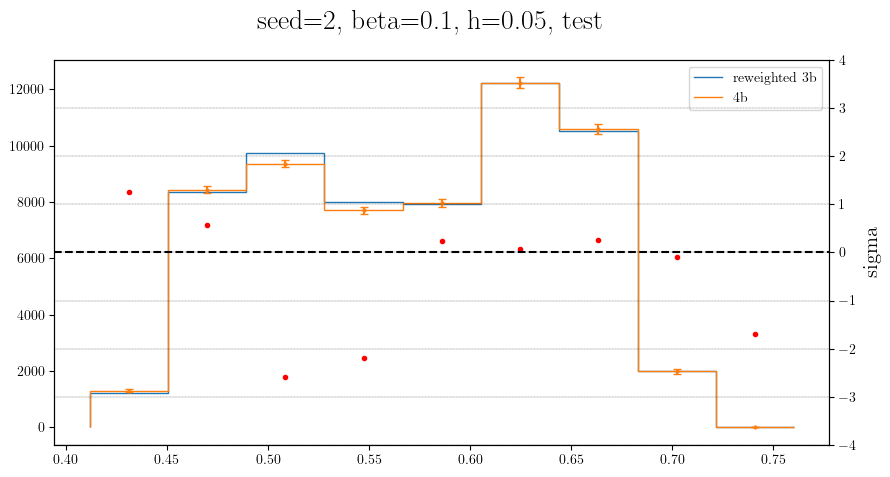

[rank: 0] Seed set to 2
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 20: 100%|██████████| 141/141 [00:08<00:00, 16.34it/s, v_num=19, val_loss=0.678, val_ce_loss=0.675, val_cal_loss=0.0313, train_loss=0.679, train_ce_loss=0.676, train_cal_loss=0.0366]


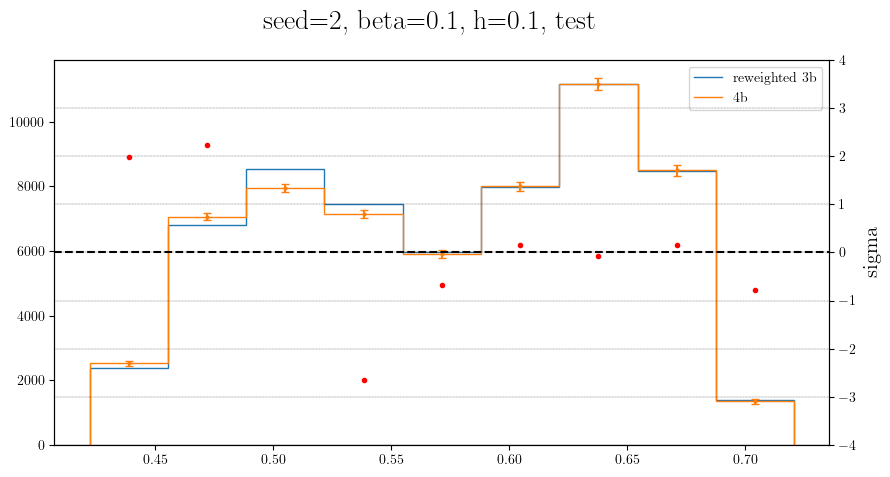

[rank: 0] Seed set to 2
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 29: 100%|██████████| 141/141 [00:09<00:00, 14.91it/s, v_num=20, val_loss=0.678, val_ce_loss=0.675, val_cal_loss=0.0301, train_loss=0.679, train_ce_loss=0.675, train_cal_loss=0.0314]


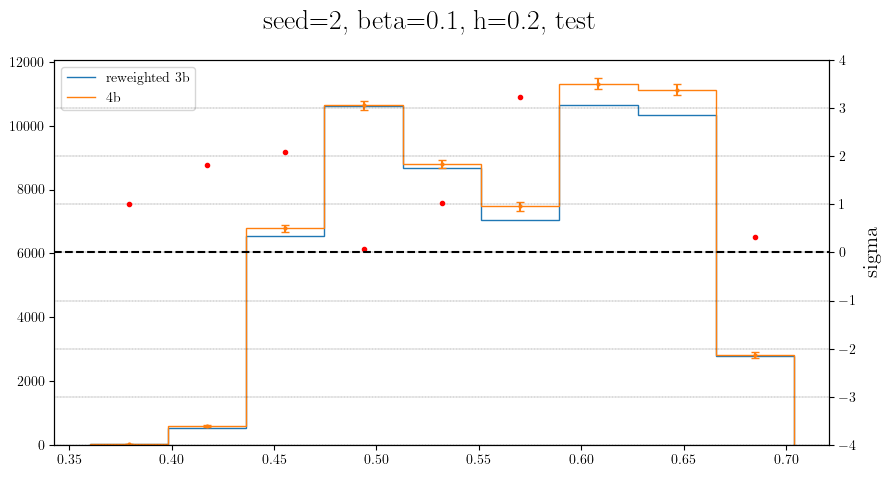

[rank: 0] Seed set to 2
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 16: 100%|██████████| 141/141 [00:10<00:00, 12.95it/s, v_num=7, val_loss=0.675, val_ce_loss=0.675, val_cal_loss=0.166, train_loss=0.676, train_ce_loss=0.676, train_cal_loss=0.166]


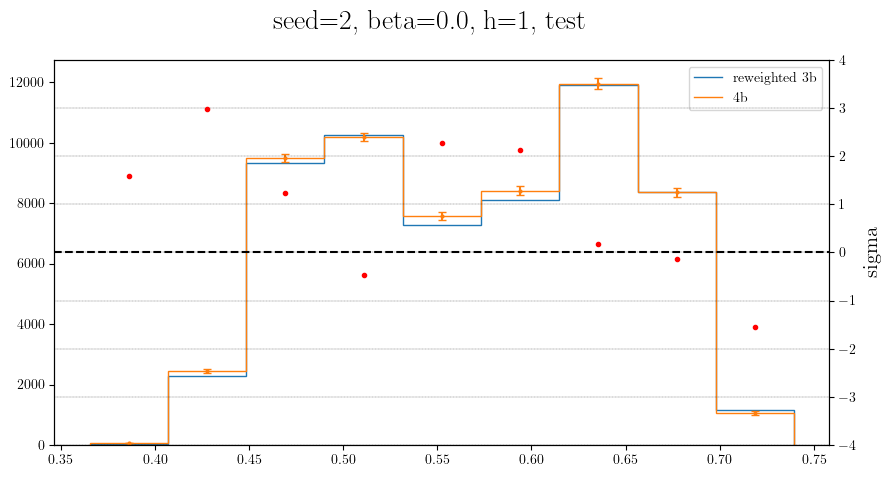

n_3b=1000000, signal_ratio=0.0, seed=3


[rank: 0] Seed set to 3
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 37: 100%|██████████| 144/144 [00:07<00:00, 18.62it/s, v_num=21, val_loss=0.684, val_ce_loss=0.681, val_cal_loss=0.0335, train_loss=0.685, train_ce_loss=0.681, train_cal_loss=0.0406]


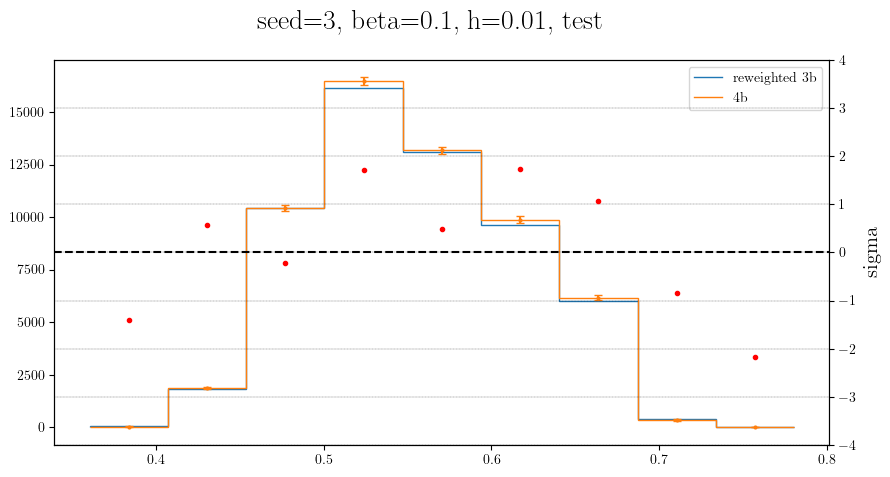

[rank: 0] Seed set to 3
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 31: 100%|██████████| 144/144 [00:07<00:00, 19.65it/s, v_num=22, val_loss=0.684, val_ce_loss=0.681, val_cal_loss=0.0313, train_loss=0.685, train_ce_loss=0.681, train_cal_loss=0.0353]


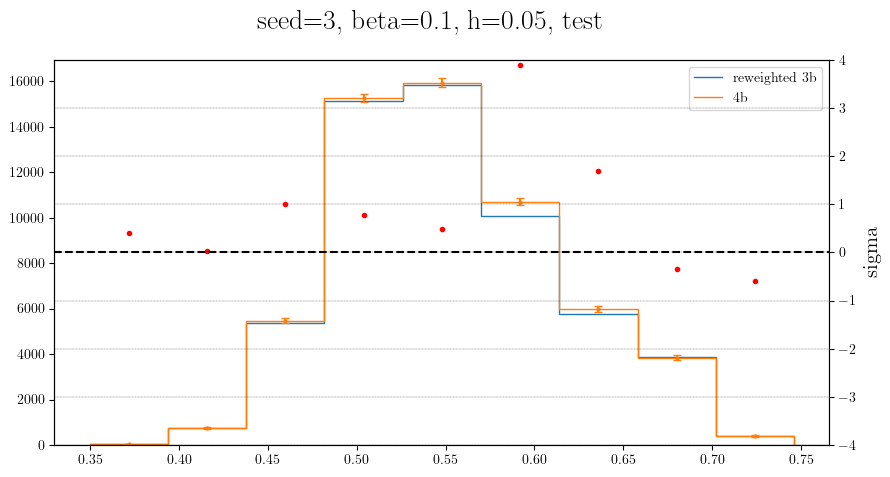

[rank: 0] Seed set to 3
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 28: 100%|██████████| 144/144 [00:07<00:00, 19.21it/s, v_num=23, val_loss=0.685, val_ce_loss=0.682, val_cal_loss=0.027, train_loss=0.685, train_ce_loss=0.681, train_cal_loss=0.0331] 


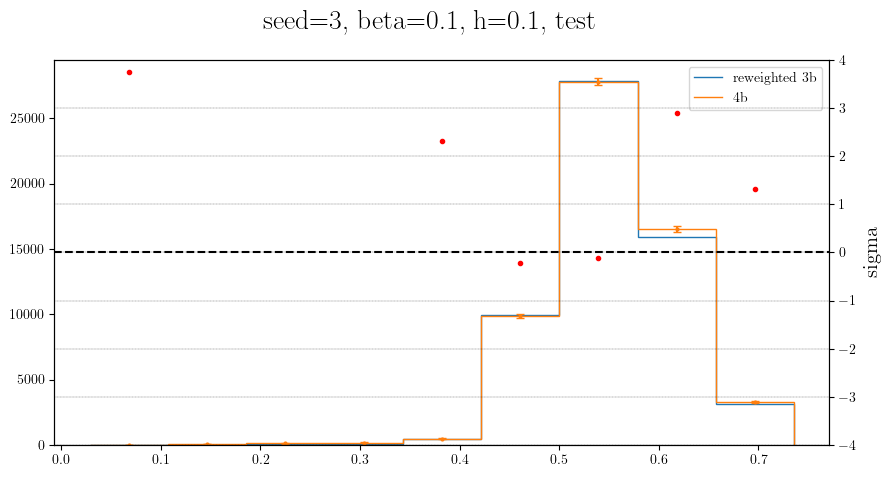

[rank: 0] Seed set to 3
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 29: 100%|██████████| 144/144 [00:07<00:00, 19.41it/s, v_num=24, val_loss=0.684, val_ce_loss=0.681, val_cal_loss=0.0261, train_loss=0.684, train_ce_loss=0.681, train_cal_loss=0.0327]


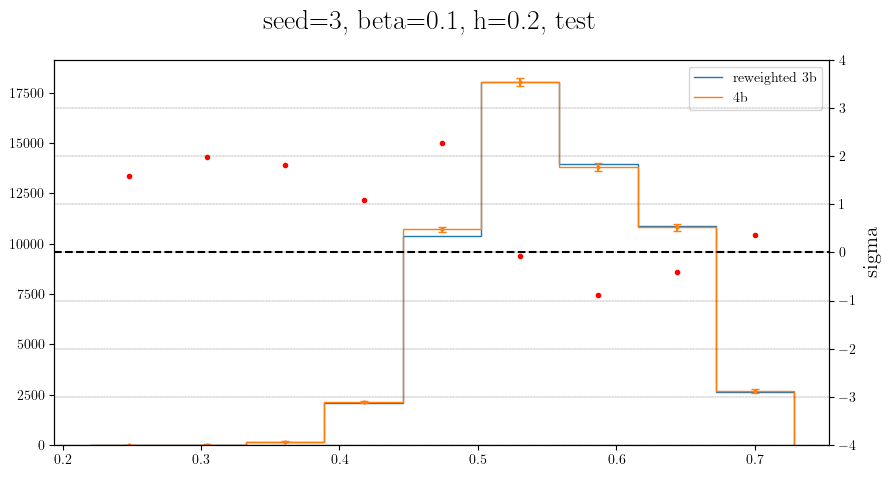

[rank: 0] Seed set to 3
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 23: 100%|██████████| 144/144 [00:07<00:00, 18.09it/s, v_num=8, val_loss=0.681, val_ce_loss=0.681, val_cal_loss=0.155, train_loss=0.681, train_ce_loss=0.681, train_cal_loss=0.147]


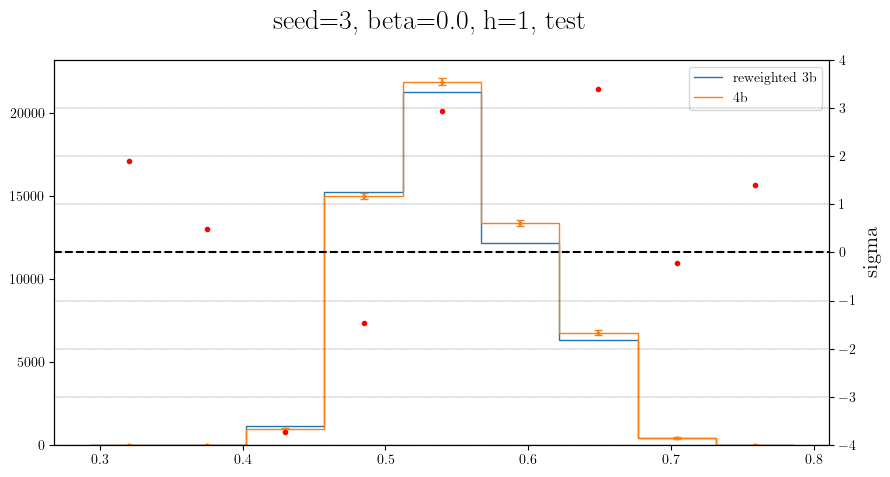

n_3b=1000000, signal_ratio=0.0, seed=4


[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 27: 100%|██████████| 145/145 [00:09<00:00, 14.67it/s, v_num=25, val_loss=0.683, val_ce_loss=0.679, val_cal_loss=0.0339, train_loss=0.684, train_ce_loss=0.680, train_cal_loss=0.0367]


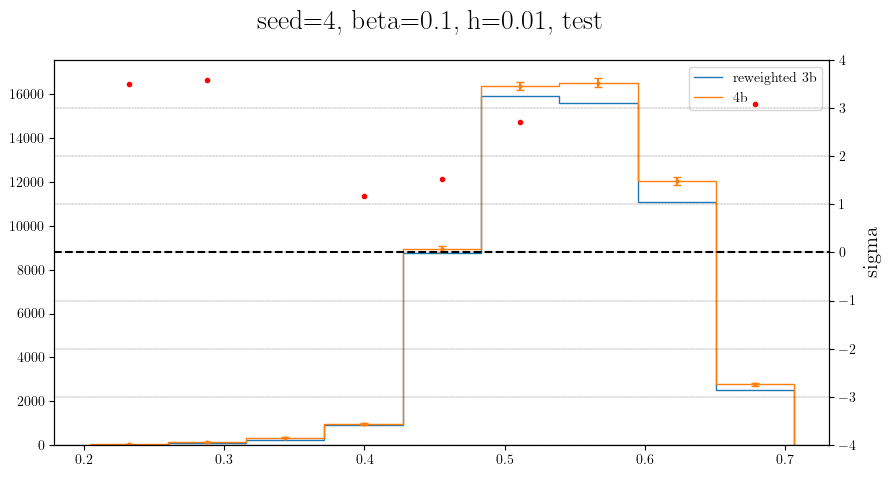

[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 26: 100%|██████████| 145/145 [00:11<00:00, 13.18it/s, v_num=26, val_loss=0.682, val_ce_loss=0.679, val_cal_loss=0.0325, train_loss=0.683, train_ce_loss=0.679, train_cal_loss=0.0343]


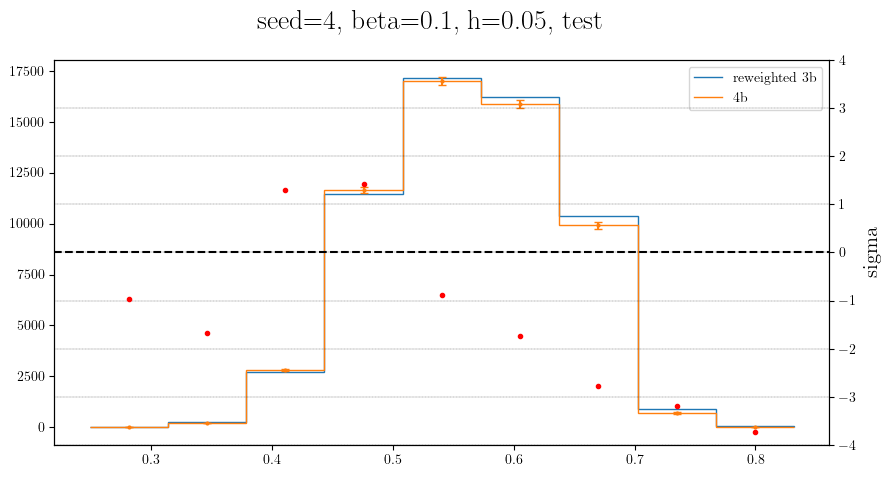

[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 31: 100%|██████████| 145/145 [00:11<00:00, 13.17it/s, v_num=27, val_loss=0.686, val_ce_loss=0.683, val_cal_loss=0.0332, train_loss=0.683, train_ce_loss=0.680, train_cal_loss=0.0371]


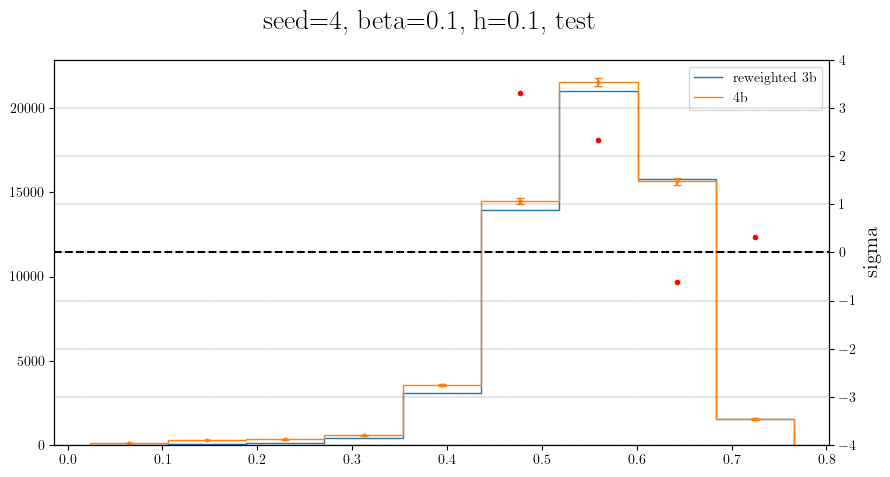

[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 20: 100%|██████████| 145/145 [00:07<00:00, 19.49it/s, v_num=28, val_loss=0.682, val_ce_loss=0.679, val_cal_loss=0.0306, train_loss=0.683, train_ce_loss=0.679, train_cal_loss=0.0319]


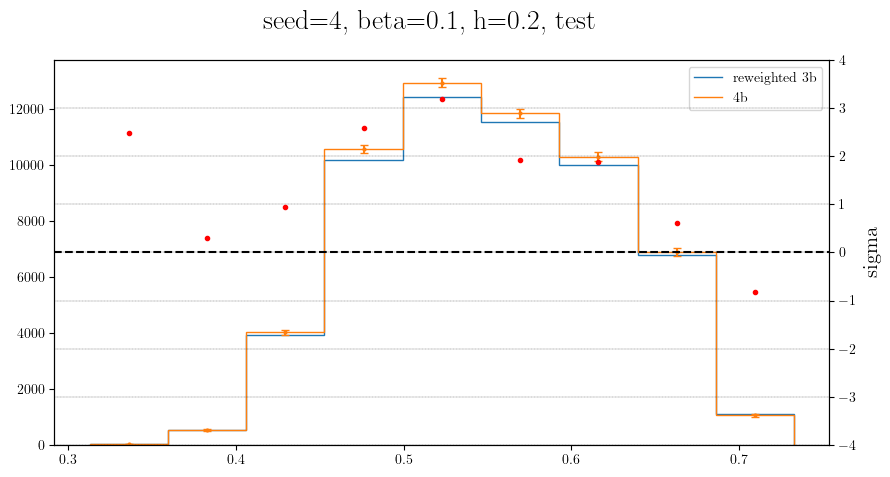

[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 23: 100%|██████████| 145/145 [00:07<00:00, 19.40it/s, v_num=9, val_loss=0.678, val_ce_loss=0.678, val_cal_loss=0.168, train_loss=0.679, train_ce_loss=0.679, train_cal_loss=0.162]


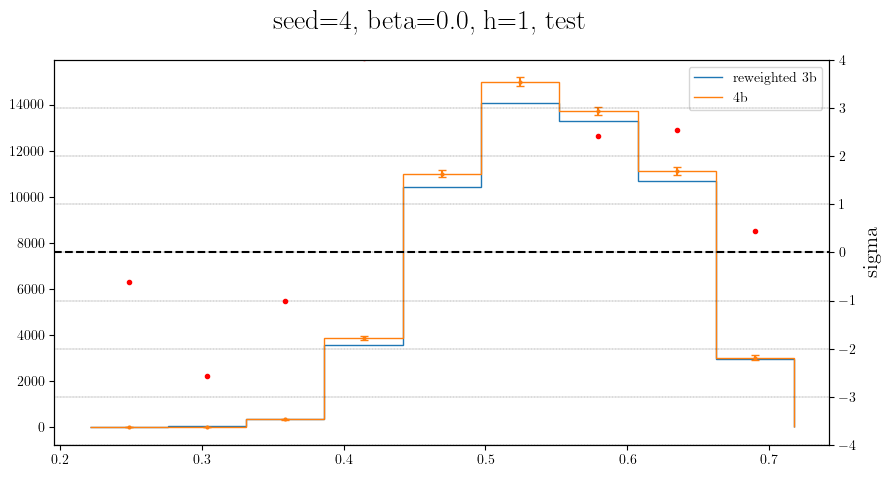

n_3b=1000000, signal_ratio=0.0, seed=5


[rank: 0] Seed set to 5
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 39: 100%|██████████| 140/140 [00:07<00:00, 18.64it/s, v_num=29, val_loss=0.674, val_ce_loss=0.673, val_cal_loss=0.0115, train_loss=0.674, train_ce_loss=0.673, train_cal_loss=0.0125]


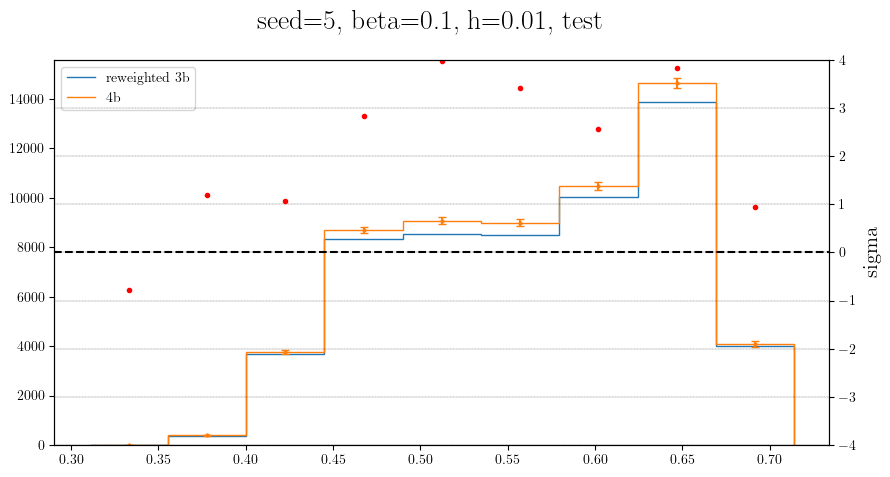

[rank: 0] Seed set to 5
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 49: 100%|██████████| 140/140 [00:06<00:00, 20.02it/s, v_num=30, val_loss=0.674, val_ce_loss=0.673, val_cal_loss=0.0139, train_loss=0.674, train_ce_loss=0.673, train_cal_loss=0.0143]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 140/140 [00:07<00:00, 19.91it/s, v_num=30, val_loss=0.674, val_ce_loss=0.673, val_cal_loss=0.0139, train_loss=0.674, train_ce_loss=0.673, train_cal_loss=0.0143]


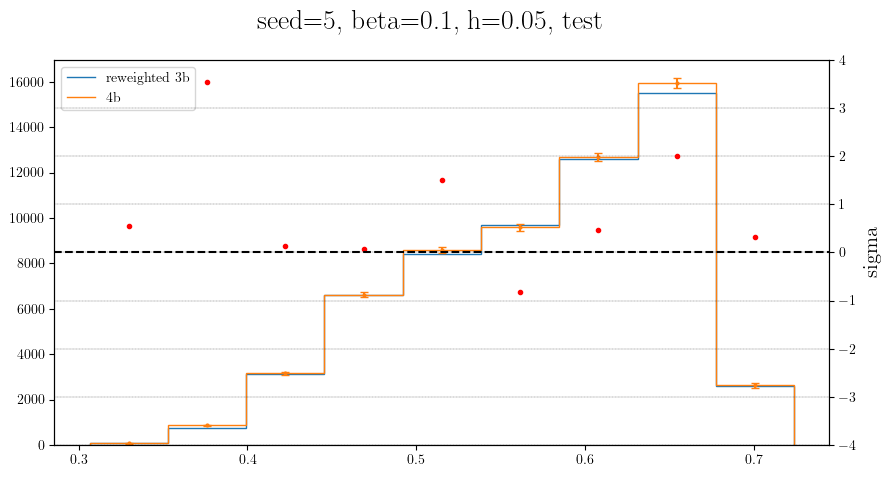

[rank: 0] Seed set to 5
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 19: 100%|██████████| 140/140 [00:07<00:00, 19.46it/s, v_num=31, val_loss=0.677, val_ce_loss=0.673, val_cal_loss=0.0351, train_loss=0.678, train_ce_loss=0.674, train_cal_loss=0.0381]


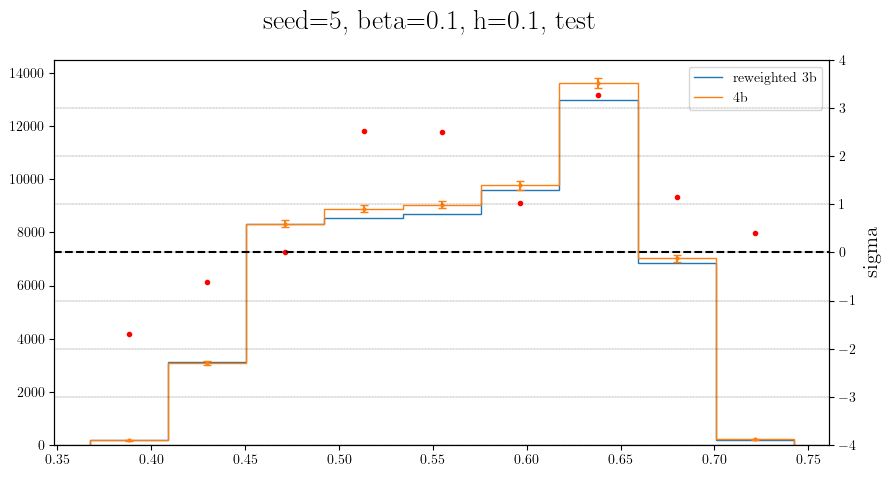

[rank: 0] Seed set to 5
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 31: 100%|██████████| 140/140 [00:09<00:00, 15.17it/s, v_num=32, val_loss=0.676, val_ce_loss=0.673, val_cal_loss=0.0303, train_loss=0.677, train_ce_loss=0.673, train_cal_loss=0.0358]


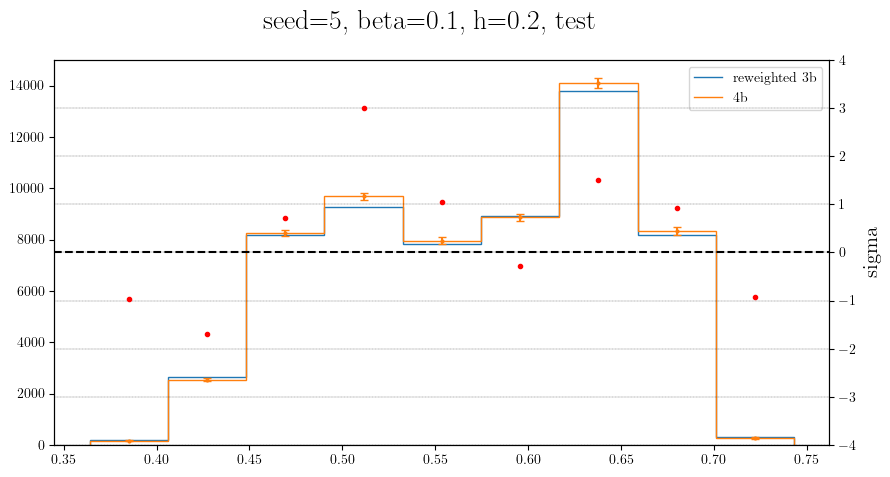

[rank: 0] Seed set to 5
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 26: 100%|██████████| 140/140 [00:10<00:00, 13.01it/s, v_num=10, val_loss=0.673, val_ce_loss=0.673, val_cal_loss=0.160, train_loss=0.673, train_ce_loss=0.673, train_cal_loss=0.160]


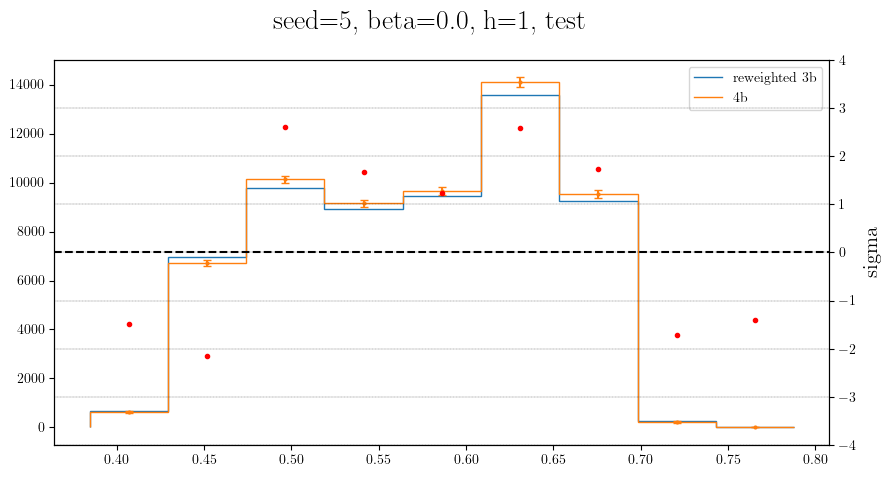

n_3b=1000000, signal_ratio=0.0, seed=6


[rank: 0] Seed set to 6
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 45: 100%|██████████| 144/144 [00:08<00:00, 16.99it/s, v_num=33, val_loss=0.682, val_ce_loss=0.679, val_cal_loss=0.0226, train_loss=0.682, train_ce_loss=0.679, train_cal_loss=0.022] 


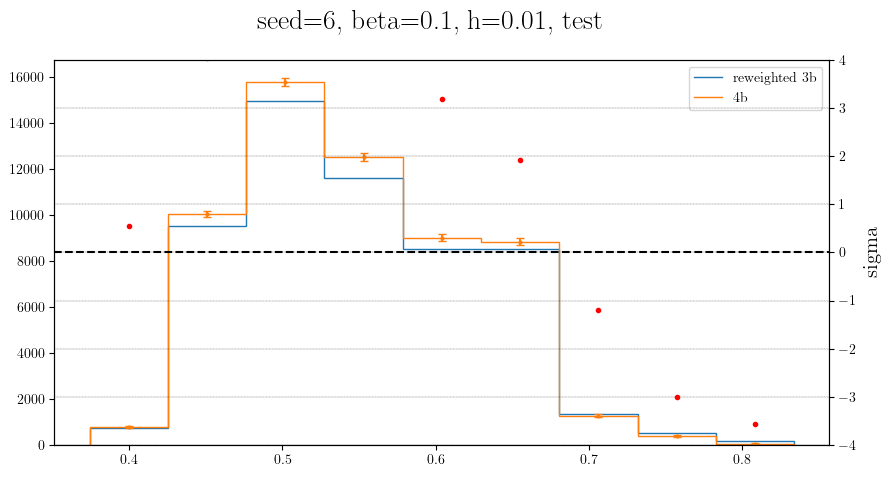

[rank: 0] Seed set to 6
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 47: 100%|██████████| 144/144 [00:08<00:00, 16.10it/s, v_num=34, val_loss=0.680, val_ce_loss=0.679, val_cal_loss=0.0152, train_loss=0.680, train_ce_loss=0.679, train_cal_loss=0.0144]


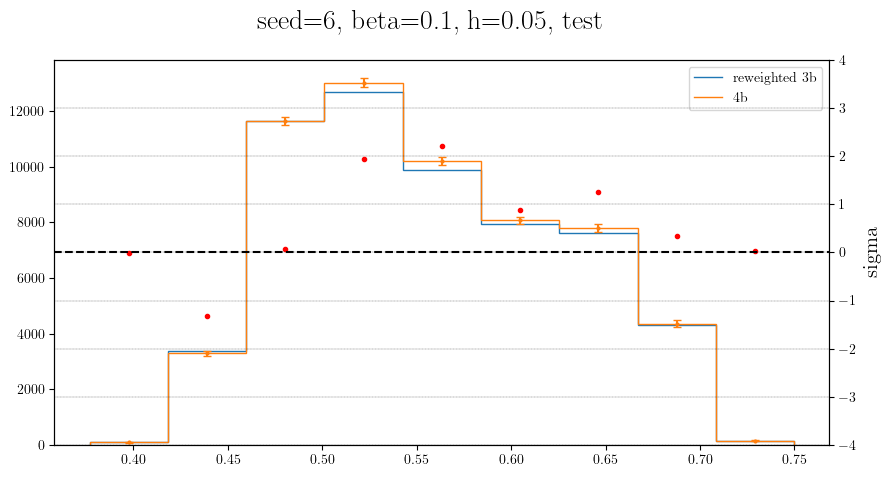

[rank: 0] Seed set to 6
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 47: 100%|██████████| 144/144 [00:08<00:00, 17.10it/s, v_num=35, val_loss=0.682, val_ce_loss=0.679, val_cal_loss=0.024, train_loss=0.682, train_ce_loss=0.679, train_cal_loss=0.0238] 


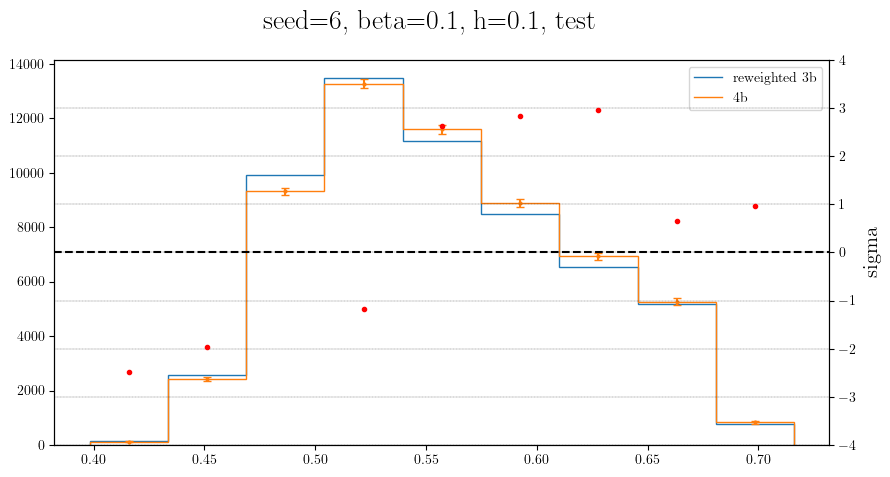

[rank: 0] Seed set to 6
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 30: 100%|██████████| 144/144 [00:07<00:00, 18.53it/s, v_num=36, val_loss=0.682, val_ce_loss=0.679, val_cal_loss=0.0282, train_loss=0.682, train_ce_loss=0.679, train_cal_loss=0.0282]


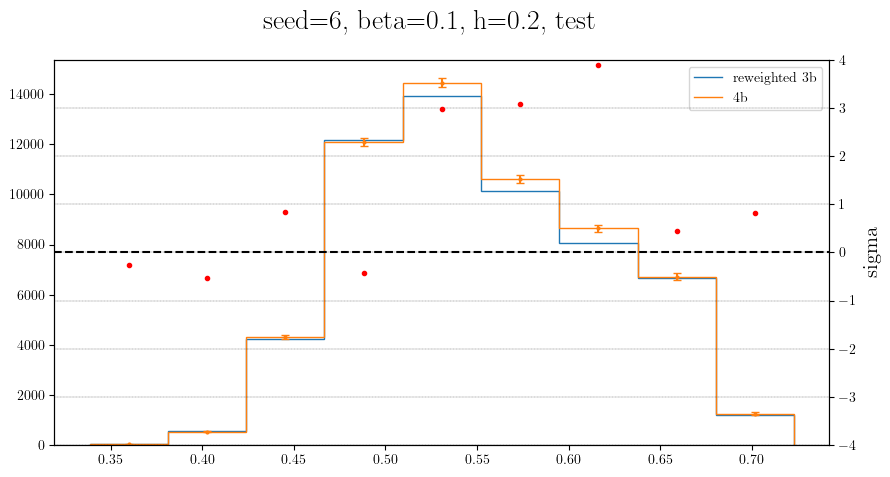

[rank: 0] Seed set to 6
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 14: 100%|██████████| 144/144 [00:08<00:00, 16.53it/s, v_num=11, val_loss=0.679, val_ce_loss=0.679, val_cal_loss=0.163, train_loss=0.680, train_ce_loss=0.680, train_cal_loss=0.161]


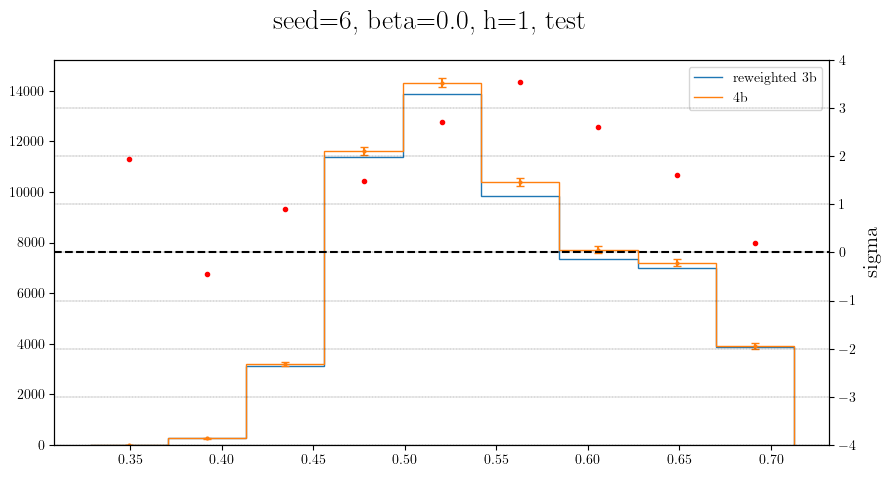

n_3b=1000000, signal_ratio=0.0, seed=7


[rank: 0] Seed set to 7
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 26: 100%|██████████| 144/144 [00:09<00:00, 15.50it/s, v_num=37, val_loss=0.684, val_ce_loss=0.680, val_cal_loss=0.0359, train_loss=0.684, train_ce_loss=0.680, train_cal_loss=0.0397]


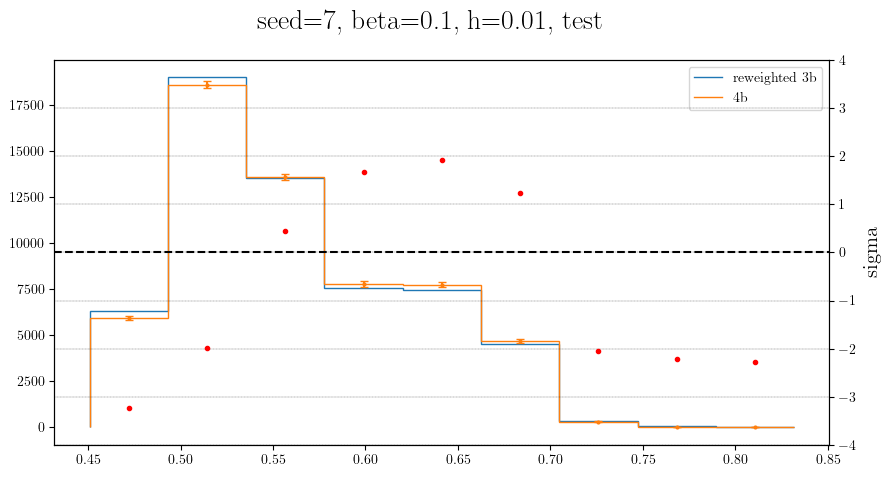

[rank: 0] Seed set to 7
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 23: 100%|██████████| 144/144 [00:10<00:00, 13.55it/s, v_num=38, val_loss=0.683, val_ce_loss=0.679, val_cal_loss=0.0378, train_loss=0.683, train_ce_loss=0.679, train_cal_loss=0.0416]


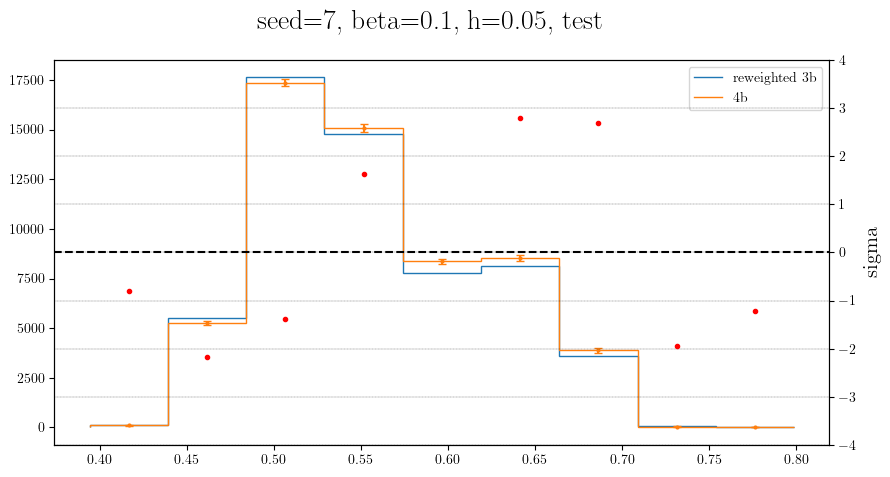

[rank: 0] Seed set to 7
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 12: 100%|██████████| 144/144 [00:11<00:00, 12.98it/s, v_num=39, val_loss=0.683, val_ce_loss=0.679, val_cal_loss=0.038, train_loss=0.684, train_ce_loss=0.680, train_cal_loss=0.0381] 


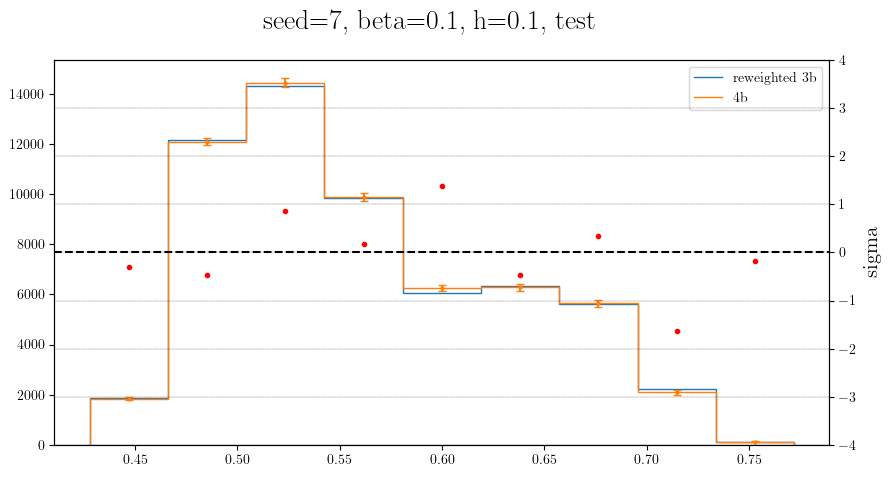

[rank: 0] Seed set to 7
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.1_best.ckpt
Epoch 7: 100%|██████████| 144/144 [00:06<00:00, 22.71it/s, v_num=40, val_loss=0.684, val_ce_loss=0.680, val_cal_loss=0.0437, train_loss=0.685, train_ce_loss=0.680, train_cal_loss=0.047] 

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


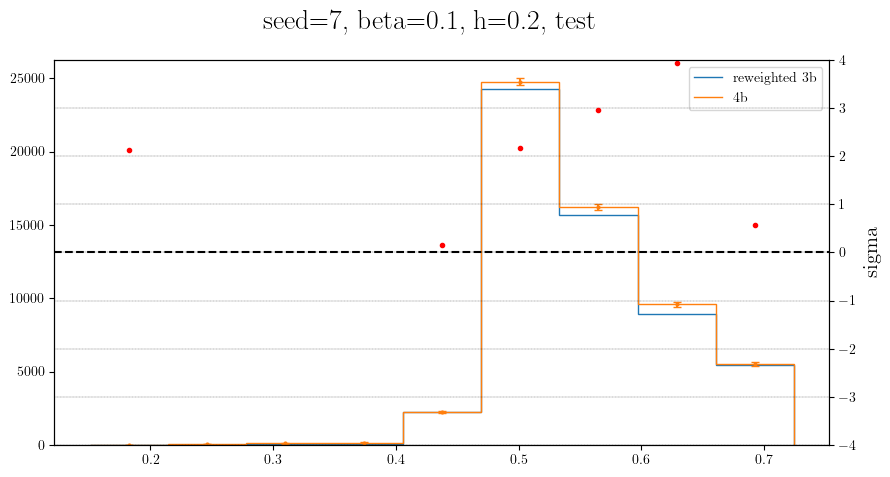

[rank: 0] Seed set to 7
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0_best.ckpt
Epoch 1:   0%|          | 0/144 [00:00<?, ?it/s, v_num=12, val_loss=0.682, val_ce_loss=0.682, val_cal_loss=0.149]          

In [6]:
from itertools import product
from training_info import TrainingInfoV2
from plots import calibration_plot, plot_rewighted_samples_by_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
cal_bins = 10
seeds = np.arange(10)

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],

    "n_3b": n_3b,
    "seed": lambda x: x in seeds,
    "signal_ratio": 0.0
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    seed = tstinfo.hparams["seed"]
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    CR_model = FvTClassifier.load_from_checkpoint(f"data/checkpoints/{CR_fvt_tinfo.hash}_best.ckpt")
    CR_model.to(device)
    CR_model.eval()
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)

    batch_size = CR_fvt_tinfo.hparams["batch_size"] # double the batch size to fit the kernel matrix
    events_train.fit_batch_size(batch_size)
    events_val.fit_batch_size(batch_size)
    SR_stat = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    events_tst_CR = events_tst[in_CR]
    events_tst_CR.shuffle(seed=0)
    events_tst_CR = events_tst_CR[:100_000]

    # shuffle events_val to calculate calibration loss
    events_train.shuffle(seed=seed)
    events_val.shuffle(seed=seed)
    events_tst_CR.shuffle(seed=seed)
    
    for calib_beta ,calib_h in list(product([0.1], [0.01, 0.05, 0.1, 0.2])) + [(0.0, 1)]:
        CR_model_new = FvTClassifier(
            num_classes=2,
            dim_input_jet_features=4, 
            dim_dijet_features=CR_fvt_tinfo.hparams["dim_dijet_features"],
            dim_quadjet_features=CR_fvt_tinfo.hparams["dim_quadjet_features"],
            run_name=f"beta={calib_beta}",
            device=device,
            lr=0.001,
            calibration_h=calib_h,
            calibration_beta=calib_beta
        )
        CR_model_new.fit(
            events_train.to_tensor_dataset(),
            events_val.to_tensor_dataset(),
            batch_size=batch_size,
            max_epochs=50,
            train_seed=seed,
            save_checkpoint=False,
            callbacks=[
                # ReweightedPlotCallback(events_train, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, train", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_val, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, val", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_tst_CR, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, test", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                ]
        )
        
        CR_model_new.load_tmp_checkpoint()
        plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, beta={calib_beta}, h={calib_h}, test", ratio_4b=ratio_4b)

n_3b=1000000, signal_ratio=0.0, seed=4


[rank: 0] Seed set to 4
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/export/soheuny/SRFinder/soheun/data/tmp/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 20.7 K
1 | select_q | conv1d     | 34    
2 | out      | conv1d     | 68    
-----

Deleting existing tmp checkpoint: data/tmp/checkpoints/beta=0.0, kernel=bins_best.ckpt


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 11: 100%|██████████| 36/36 [00:04<00:00,  8.12it/s, v_num=3, val_loss=0.678, val_ce_loss=0.678, val_cal_loss=0.0129, train_loss=0.678, train_ce_loss=0.678, train_cal_loss=0.0155]


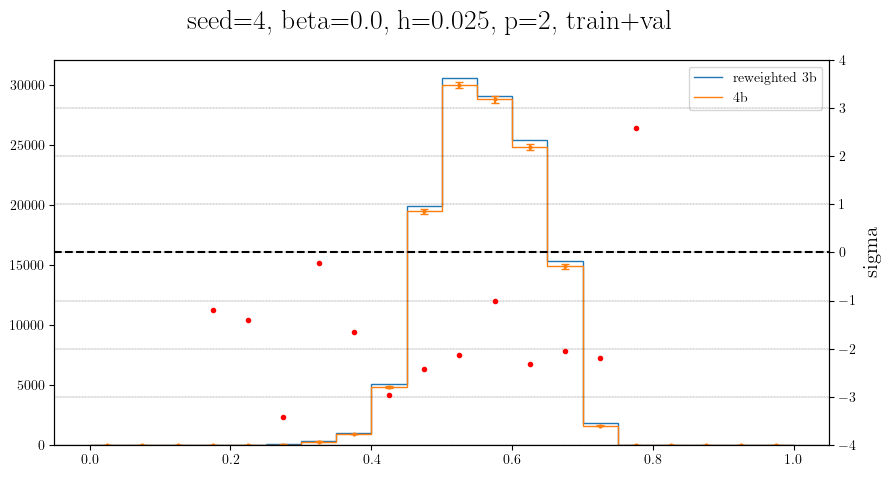

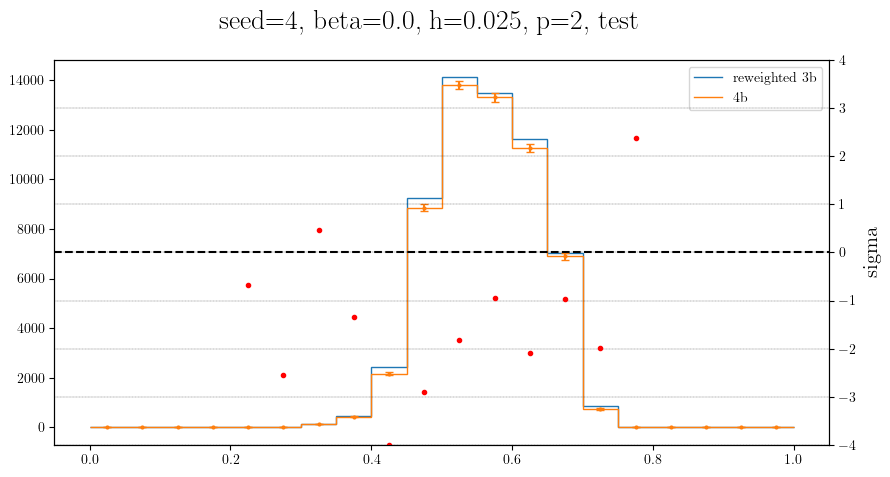

In [12]:
from itertools import product
from training_info import TrainingInfoV2
from plots import calibration_plot, plot_rewighted_samples_by_model, plot_rewighted_samples_by_model_v2
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
cal_bins = np.linspace(0, 1, 21)
seeds = [4]

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],

    "n_3b": n_3b,
    "seed": lambda x: x in seeds,
    "signal_ratio": 0.0
}
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    seed = tstinfo.hparams["seed"]
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    CR_model = FvTClassifier.load_from_checkpoint(f"data/checkpoints/{CR_fvt_tinfo.hash}_best.ckpt")
    CR_model.to(device)
    CR_model.eval()
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)


    # batch_size = CR_fvt_tinfo.hparams["batch_size"] # double the batch size to fit the kernel matrix
    batch_size = 2 ** 12
    SR_stat = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    events_tst_CR = events_tst[in_CR]

    # shuffle events_val to calculate calibration loss
    events_train.shuffle(seed=seed)
    events_val.shuffle(seed=seed)
    events_tst_CR.shuffle(seed=seed)
    
    events_train.fit_batch_size(batch_size)
    events_val.fit_batch_size(batch_size)
    events_tst_CR = events_tst_CR[:100_000]
    
    cheating_beta = 0.0
    cheating_h = 0.1
    

    for calib_beta ,calib_h, calib_p, calib_kernel_type in list(product([0.0], [0.025], [2], ["bins"])):
        CR_model_new = FvTClassifier(
            num_classes=2,
            dim_input_jet_features=4, 
            dim_dijet_features=32,
            dim_quadjet_features=32,
            run_name=f"beta={calib_beta}, kernel={calib_kernel_type}",
            device=device,
            lr=0.001,
            calibration_h=calib_h,
            calibration_beta=calib_beta,
            cheating_beta=cheating_beta,
            cheating_h=cheating_h
        )
        CR_model_new.fit(
            events_train.to_tensor_dataset(),
            events_val.to_tensor_dataset(),
            batch_size=batch_size,
            max_epochs=50,
            train_seed=seed,
            save_checkpoint=False,
            callbacks=[
                # ReweightedPlotCallback(events_train, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, train", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_val, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, val", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                # ReweightedPlotCallback(events_tst_CR, bins=cal_bins, figsize=(10, 5), title=f"beta={calib_beta}, test", 
                #                        plot_every_n_epochs=10, ratio_4b=ratio_4b),
                ]
        )
        
        CR_model_new.load_tmp_checkpoint()
        plot_rewighted_samples_by_model(CR_model_new, EventsData.merge([events_train, events_val]), bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, train+val", ratio_4b=ratio_4b)
        plot_rewighted_samples_by_model(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
                                        title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, test", ratio_4b=ratio_4b)
        # plot_rewighted_samples_by_model_v2(CR_model_new, events_tst_CR, bins=cal_bins, figsize=(10, 5), 
        #                                 title=f"seed={seed}, beta={calib_beta}, h={calib_h}, p={calib_p}, test", ratio_4b=ratio_4b)
        


/tmp/ipykernel_3809677/1991611391.py:20: RuntimeWarning: invalid value encountered in scalar divide
  acc_by_bin[i] = (random_events.is_4b * random_events.weights)[bin_idx == i].sum() / random_events.weights[bin_idx == i].sum()


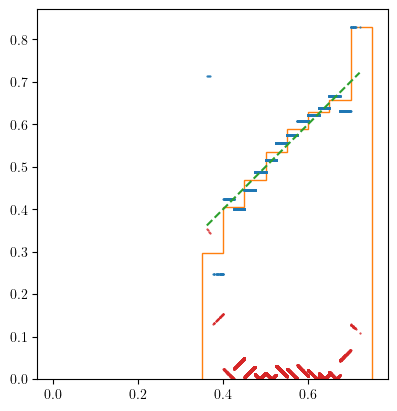

In [10]:
from fvt_classifier import kernel

random_idx = np.random.choice(len(events_tst_CR), size=2**14)
random_events = events_tst_CR[random_idx]
preds = CR_model_new.predict(random_events.X_torch.to(device))[:, 1]
K = kernel(preds, preds, CR_model_new.calibration_h, kernel_type="bins")
K = K * random_events.weights.reshape(1, -1)  # is this correct?
K = K / K.sum(dim=1, keepdim=True)
acc = (K @ random_events.is_4b_torch.to(torch.float32).reshape(-1, 1)).reshape(-1)
acc = acc.detach().cpu().numpy()
preds = preds.detach().cpu().numpy()


nbins = 20
bins = np.linspace(0, 1, nbins + 1)
bin_idx = np.digitize(preds, bins)
bin_idx = np.clip(bin_idx, 1, nbins - 1) - 1
acc_by_bin = np.zeros(nbins)
for i in range(nbins):
    acc_by_bin[i] = (random_events.is_4b * random_events.weights)[bin_idx == i].sum() / random_events.weights[bin_idx == i].sum()

plt.figure()
plt.plot(preds, acc, ".", markersize=1)
plt.stairs(acc_by_bin, bins, fill=False)
plt.plot((np.min(preds), np.max(preds)), (np.min(preds), np.max(preds)), "--")
plt.plot(preds, np.abs(acc - preds), ".", markersize=1)
plt.gca().set_aspect("equal")
plt.show()
plt.close()



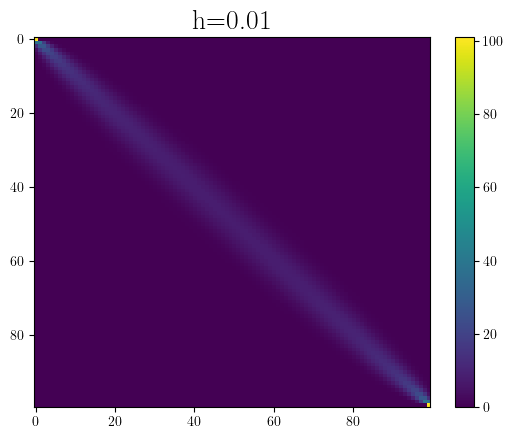

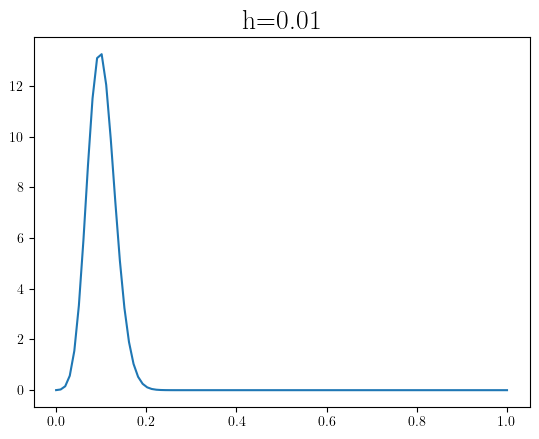

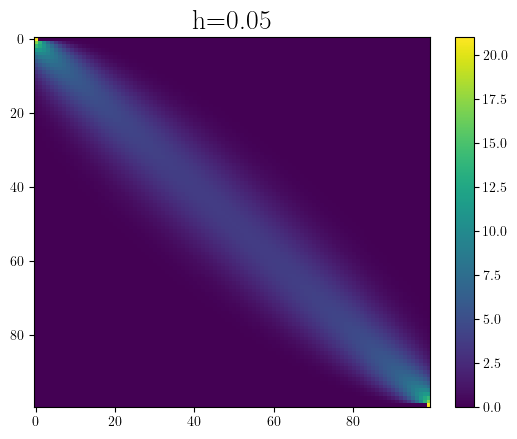

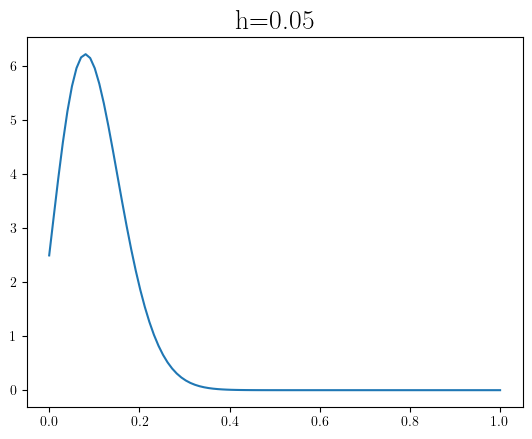

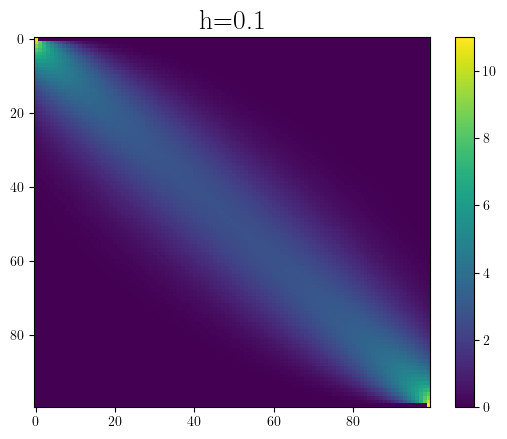

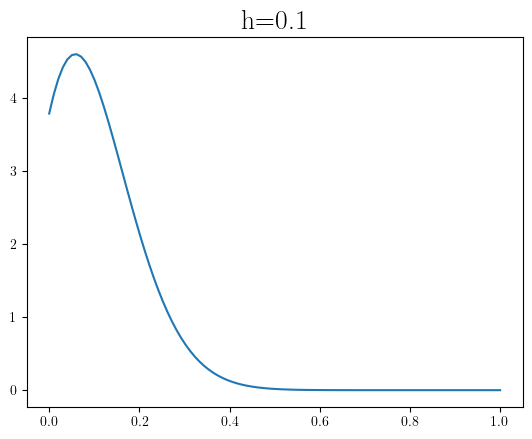

In [26]:
nbins = 100
x = torch.linspace(0, 1, nbins)
y = torch.linspace(0, 1, nbins)
for h in [0.01, 0.05, 0.1]:
    kernel_matrix = kernel(x, y, h=h, kernel_type="dirichlet").detach().cpu().numpy()
    plt.figure()
    plt.title(f"h={h}")
    plt.imshow(kernel_matrix, aspect="auto")
    plt.colorbar()
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title(f"h={h}")
    plt.plot(x, kernel_matrix[nbins//10])
    plt.show()
    plt.close()